This notebook is focused on using reinforcement learning to train an agent that can efficiently manage network resources, particularly Baseband Units (BBUs), in a telecommunications network. The BBUEnvironment simulates real-world conditions by providing state information (such as energy consumption and latency) and rewarding or penalizing the agent based on its decisions. The agent is trained using a DQN model to optimize throughput and latency while minimizing energy consumption, and its performance is evaluated over multiple training episodes.

# **Step 1: Install Libraries**

In [ ]:
pip install pandas numpy scikit-learn tabulate torch seaborn tensorflow 

## Colab

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import gc

# Call garbage collection after certain episodes to clear unused memory
gc.collect()

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!nvidia-smi

# **Step 2: Import Libraries and Load the Dataset**
In the next cell, import the required libraries and load the dataset:


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import os
import logging
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load the dataset
file_path = '/home/xkolac15/pesbiu2.0/data/combined_granular_all_sites_predicted_incl.csv'
#file_path = 'data/combined_granular_all_sites.csv'
#file_path = 'data/combined_granular_all_sites_evalshift.csv'
df = pd.read_csv(file_path)

# Ensure 'Datetime' is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort the dataset by datetime
df = df.sort_values('Datetime')

# Display the first few rows to understand the dataframe
print("First few rows of the dataset:")
print(df.head())


First few rows of the dataset:
             Datetime Time interval [hh:mm] Day of Week  Month  \
0 2024-06-09 00:00:00               0:00:00      Sunday      6   
1 2024-06-09 00:15:00               0:15:00      Sunday      6   
2 2024-06-09 00:30:00               0:30:00      Sunday      6   
3 2024-06-09 00:45:00               0:45:00      Sunday      6   
4 2024-06-09 01:00:00               1:00:00      Sunday      6   

   B1 Total port Tput [Mbps]  B1 UE DlLatency [ms]  \
0                     14.718                   4.5   
1                      9.095                   6.8   
2                      8.958                   6.6   
3                     11.873                   5.3   
4                     10.183                   5.9   

   B1 BBU1 AVG Power consumption [W]  B2 Total port Tput [Mbps]  \
0                              137.8                     28.077   
1                              137.8                     26.430   
2                              137.6          

# **Step 3: Preprocess the Dataset**
This part of the code performs a **linear regression analysis** to model the relationship between **throughput**, **energy consumption**, and **latency** for three different Baseband Units (BBUs): B1, B2, and B3. The goal is to calculate coefficients that describe how energy consumption and latency change as throughput increases.

This section of code focuses on data preprocessing. It extracts relevant columns from the dataset, handles datetime and categorical features, and then normalizes the data for further machine learning tasks.

In [3]:
# Function to calculate coefficients for a given BBU
def calculate_coefficients(throughput, energy, latency):
    energy_reg = LinearRegression().fit(throughput, energy)
    k_B = energy_reg.coef_[0][0]
    E_base_B = energy_reg.intercept_[0]

    latency_reg = LinearRegression().fit(throughput, latency)
    m_B = latency_reg.coef_[0][0]
    L_base_B = latency_reg.intercept_[0]

    return k_B, E_base_B, m_B, L_base_B

# Function to preprocess states
def preprocess_states(df, cell_sites):
    # Extract relevant columns for all cell sites
    selected_columns = ['Datetime', 'Time interval [hh:mm]', 'Day of Week', 'Month']
    for site in cell_sites:
        for bbu in range(1, 4):
            selected_columns += [
                f'{site}{bbu} Total port Tput [Mbps]',
                f'{site}{bbu} UE DlLatency [ms]',
                f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
            ]
    states = df[selected_columns].copy()

    # Parse 'Time interval [hh:mm]' to datetime
    states['Time interval [hh:mm]'] = pd.to_datetime(states['Time interval [hh:mm]'], format='%H:%M:%S')

    # Extract 'Hour' and 'Minute'
    states['Hour'] = states['Time interval [hh:mm]'].dt.hour
    states['Minute'] = states['Time interval [hh:mm]'].dt.minute

    # Create 'Hour_decimal'
    states['Hour_decimal'] = states['Hour'] + states['Minute'] / 60

    # Map 'Day of Week' to numerical values
    day_mapping = {'Monday': 0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
    states['Day'] = states['Day of Week'].map(day_mapping)

    # Drop unnecessary columns
    states = states.drop(['Time interval [hh:mm]', 'Day of Week', 'Hour', 'Minute'], axis=1)

    # Rearrange columns
    ordered_columns = ['Datetime', 'Hour_decimal', 'Day', 'Month']
    for site in cell_sites:
        for bbu in range(1, 4):
            ordered_columns += [
                f'{site}{bbu} Total port Tput [Mbps]',
                f'{site}{bbu} UE DlLatency [ms]',
                f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
            ]
    states = states[ordered_columns]

    return states

# Define cell sites
cell_sites = ['B', 'D', 'G']

# Preprocess the data
states = preprocess_states(df, cell_sites)

# Print the date range in the data
print("Date range in the data:", states['Datetime'].min(), "to", states['Datetime'].max())

# Initialize separate scalers for each cell site
scalers = {}
for site in cell_sites:
    # Define the columns relevant to the site
    site_columns = ['Hour_decimal', 'Day', 'Month']
    for bbu in range(1, 4):
        site_columns += [
            f'{site}{bbu} Total port Tput [Mbps]',
            f'{site}{bbu} UE DlLatency [ms]',
            f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
        ]
    # Extract data for the site
    site_data = states[site_columns]
    # Fit the scaler
    scaler = StandardScaler()
    scaler.fit(site_data)
    scalers[site] = scaler
    print(f"Scaler fitted for cell site {site}.")

print("\nPreprocessed states (first 5 rows):")
print(states.head())

Date range in the data: 2024-06-09 00:00:00 to 2024-06-23 02:15:00
Scaler fitted for cell site B.
Scaler fitted for cell site D.
Scaler fitted for cell site G.

Preprocessed states (first 5 rows):
             Datetime  Hour_decimal  Day  Month  B1 Total port Tput [Mbps]  \
0 2024-06-09 00:00:00          0.00    6      6                     14.718   
1 2024-06-09 00:15:00          0.25    6      6                      9.095   
2 2024-06-09 00:30:00          0.50    6      6                      8.958   
3 2024-06-09 00:45:00          0.75    6      6                     11.873   
4 2024-06-09 01:00:00          1.00    6      6                     10.183   

   B1 UE DlLatency [ms]  B1 BBU1 AVG Power consumption [W]  \
0                   4.5                              137.8   
1                   6.8                              137.8   
2                   6.6                              137.6   
3                   5.3                              137.4   
4                   5.9 

In [4]:
# Function to calculate coefficients for all BBUs across all cell sites
def calculate_all_coefficients(df, cell_sites):
    coefficients = {}
    max_throughputs = {}
    for site in cell_sites:
        for bbu in range(1, 4):
            throughput = df[[f'{site}{bbu} Total port Tput [Mbps]']].values
            energy = df[[f'{site}{bbu} BBU{bbu} AVG Power consumption [W]']].values
            latency = df[[f'{site}{bbu} UE DlLatency [ms]']].values

            k, E_base, m, L_base = calculate_coefficients(throughput, energy, latency)
            coefficients[f'{site}{bbu}'] = {'k': k, 'E_base': E_base, 'm': m, 'L_base': L_base}

            max_throughput = df[f'{site}{bbu} Total port Tput [Mbps]'].max()
            max_throughputs[f'{site}{bbu}'] = max_throughput
            print(f"{site}{bbu}: k={k}, E_base={E_base}, m={m}, L_base={L_base}, Max Throughput={max_throughput} Mbps")
    return coefficients, max_throughputs

# Calculate coefficients and max throughput for all BBUs
coefficients, max_throughputs = calculate_all_coefficients(df, cell_sites)

B1: k=0.1106017685257535, E_base=136.28959023329617, m=0.06651292315148054, L_base=6.271170454209134, Max Throughput=49.489 Mbps
B2: k=0.09275544029873362, E_base=113.40506925464769, m=0.09065553575703027, L_base=5.360850107500669, Max Throughput=62.866 Mbps
B3: k=0.13261676651690776, E_base=117.3871116716952, m=0.03625717542643983, L_base=6.659040792559112, Max Throughput=51.309 Mbps
D1: k=0.047895643887443586, E_base=135.82009123972068, m=0.0528644928736454, L_base=5.370403367034799, Max Throughput=76.253 Mbps
D2: k=0.03889117118977245, E_base=131.8896300691865, m=-0.0008142086022147432, L_base=7.863925758903384, Max Throughput=93.469 Mbps
D3: k=0.028217357502560707, E_base=111.58186321893143, m=0.020099640179217, L_base=6.810974850787306, Max Throughput=85.647 Mbps
G1: k=0.10705005354276541, E_base=138.43477778401677, m=0.04361081344738558, L_base=6.527142977712773, Max Throughput=62.921 Mbps
G2: k=0.04983096594500049, E_base=130.7090461143764, m=0.019891561815818817, L_base=5.92641

# **Step 4: BBU Enviroment Set Up**
This class simulates a reinforcement learning environment for optimizing the energy consumption of Baseband Units (BBUs) in a cellular network. The environment models traffic, energy, and latency at different time steps, allowing for dynamic decision-making based on current network conditions. Below is a detailed explanation of each component of the class.

In [5]:
class MultiAgentBBUEnvironment:
    def __init__(self, states, coefficients, max_throughputs, cell_sites,
                 scalers, columns, max_utilization=0.8, coefficient=1.1,
                 action_size=7):
        self.states_df = states.reset_index(drop=True)
        self.states = states.drop(columns=['Datetime']).to_numpy()
        self.columns = columns  # Store columns for internal use
        self.current_step = 0
        self.cell_sites = cell_sites
        self.num_agents = len(cell_sites)
        self.action_size = action_size
        self.scalers = scalers  # Store scalers for each cell site
        self.max_utilization = max_utilization
        self.coefficient = coefficient

        # Initialize BBU status for all cell sites (1 active, 0 inactive)
        self.bbu_status = {site: np.array([1, 1, 1]) for site in cell_sites}

        # Define valid actions (same for all agents)
        self.valid_actions = {
            0: [1, 0, 0],  # Only BBU1 active
            1: [0, 1, 0],  # Only BBU2 active
            2: [0, 0, 1],  # Only BBU3 active
            3: [1, 1, 0],  # BBU1 and BBU2 active
            4: [1, 0, 1],  # BBU1 and BBU3 active
            5: [0, 1, 1],  # BBU2 and BBU3 active
            6: [1, 1, 1],  # All BBUs active
        }

        # Store coefficients and max throughputs
        self.coefficients = coefficients
        self.max_throughputs = max_throughputs

        # Max capacity per BBU after applying utilization factor
        self.max_capacity_per_bbu = {bbu: self.max_throughput_for_bbu(bbu) for bbu in max_throughputs}

        # Configure logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

        # Define maximum allowable latency increase per step to prevent spikes
        self.MAX_LATENCY_INCREASE = 10  # Adjust based on system requirements

        # Define maximum allowable overload traffic
        self.MAX_OVERLOAD = 10  # Adjust based on system requirements

    def max_throughput_for_bbu(self, bbu):
        """
        Calculate the maximum capacity for a given BBU after applying utilization factors.
        """
        return self.max_throughputs[bbu] * self.max_utilization * self.coefficient  

    def reset(self):
        """
        Reset the environment to the initial state.
        Returns the initial states for all agents.
        """
        self.current_step = 0
        self.bbu_status = {site: np.array([1, 1, 1]) for site in self.cell_sites}
        states = self._get_state()
        return states.copy()

    def _get_state(self):
        """
        Retrieve the current state for all agents, including BBU statuses.
        Returns a dictionary with cell site as keys and their respective states.
        """
        state = self.states[self.current_step, :].copy()
        agent_states = {}
        for idx, site in enumerate(self.cell_sites):
            # Assuming each cell site has 3 BBUs, each with throughput, latency, and energy
            base_idx = 3 + idx * 9  # 3 common features + 9 features per cell site
            agent_state = state[:3].copy()  # Hour_decimal, Day, Month
            for bbu in range(1, 4):
                agent_state = np.append(agent_state, state[base_idx + (bbu-1)*3 : base_idx + (bbu-1)*3 + 3])
            # Append BBU status
            agent_state = np.append(agent_state, self.bbu_status[site])
            agent_states[site] = agent_state
        return agent_states

    def step(self, actions):
        """
        Take actions for all agents in the environment.

        Parameters:
        - actions: Dictionary with cell site as keys and action indices as values.

        Returns:
        - next_states: Dictionary with cell site as keys and their next states.
        - rewards: Dictionary with cell site as keys and their rewards.
        - done: Boolean indicating if the episode has ended.
        - energy_consumptions: Dictionary with energy consumption per site.
        - latencies: Dictionary with average latency per site.
        - throughputs: Dictionary with total throughput per site.
        - info: Additional info including metrics before and after actions.
        """
        done = self.current_step >= len(self.states) - 1
        if done:
            self.logger.info("Episode finished.")
            return None, None, done, None, None, None, None

        # Current state's values
        current_step = self.current_step
        state = self.states[current_step, :].copy()

        # Initialize updated values and rewards
        rewards = {}
        energy_consumptions = {}
        latencies = {}
        throughputs = {}
        info = {}

        for site in self.cell_sites:
            action = actions[site]
            # Get current BBUs' indices for the site
            bbu_indices = []
            for bbu in range(1, 4):
                col = f'{site}{bbu} Total port Tput [Mbps]'
                try:
                    bbu_idx = list(self.columns).index(col)
                except ValueError:
                    raise ValueError(f"Column {col} not found in provided columns.")
                bbu_indices.append(bbu_idx)

            # Extract all three BBUs' throughput, latency, and energy as arrays
            current_throughput = state[bbu_indices].copy()  # Array of 3 elements
            current_latency = state[[idx + 1 for idx in bbu_indices]].copy()  # Array of 3 elements
            current_energy = state[[idx + 2 for idx in bbu_indices]].copy()  # Array of 3 elements

            # Store metrics before action
            metrics_before = {
                'throughput': current_throughput.copy(),
                'latency': current_latency.copy(),
                'energy': current_energy.copy(),
            }

            # Get action mapping
            action_mapping = self.valid_actions[action]
            self.bbu_status[site] = np.array(action_mapping)

            active_bbues = [i for i, status in enumerate(self.bbu_status[site]) if status == 1]
            bbues_to_sleep = [i for i in range(3) if i not in active_bbues]

            # Set throughput and energy to zero for sleeping BBUs
            updated_throughput = current_throughput.copy()
            updated_latency = current_latency.copy()
            updated_energy = current_energy.copy()

            for bbu in bbues_to_sleep:
                updated_throughput[bbu] = 0
                updated_energy[bbu] = 0

            # Total traffic to redistribute
            total_traffic_to_redistribute = np.sum(current_throughput[bbues_to_sleep])

            # Compute available capacities
            available_capacities = []
            for bbu in active_bbues:
                bbu_id = f'{site}{bbu+1}'  # BBU indices start at 1
                available_capacity = self.max_capacity_per_bbu[bbu_id] - updated_throughput[bbu]
                available_capacities.append(available_capacity)

            total_available_capacity = np.sum(available_capacities)

            overload_traffic = 0
            if total_available_capacity > 0 and total_traffic_to_redistribute > 0:
                # Proportionally distribute the traffic based on available capacities
                redistributed_traffic = 0  # Track total redistributed traffic
                for i, bbu in enumerate(active_bbues):
                    proportion = available_capacities[i] / total_available_capacity
                    additional_throughput = proportion * total_traffic_to_redistribute
                    # Ensure that additional_throughput does not exceed available_capacity
                    additional_throughput = min(additional_throughput, available_capacities[i])
                    updated_throughput[bbu] += additional_throughput
                    redistributed_traffic += additional_throughput

                    # Update latency based on additional throughput with cap
                    latency_increase = self.coefficients[f'{site}{bbu+1}']['m'] * additional_throughput
                    latency_increase = min(latency_increase, self.MAX_LATENCY_INCREASE)
                    updated_latency[bbu] += latency_increase

                    # Update energy based on new throughput
                    updated_energy[bbu] = self.coefficients[f'{site}{bbu+1}']['E_base'] + \
                                           self.coefficients[f'{site}{bbu+1}']['k'] * updated_throughput[bbu]

                # Calculate remaining overload
                remaining_overload = total_traffic_to_redistribute - redistributed_traffic
                overload_traffic += max(remaining_overload, 0)
            else:
                # No capacity to handle any additional traffic
                overload_traffic += total_traffic_to_redistribute

            # Compute reward
            reward = self.compute_reward(site, current_energy, updated_energy,
                                        current_latency, updated_latency,
                                        current_throughput, updated_throughput,
                                        overload_penalty=overload_traffic,
                                        action=action)
            rewards[site] = reward

            # Update the state with new values
            for bbu in range(1, 4):
                state_idx = bbu_indices[bbu-1]
                state[state_idx] = updated_throughput[bbu-1]
                state[state_idx + 1] = updated_latency[bbu-1]
                state[state_idx + 2] = updated_energy[bbu-1]

            # Collect metrics
            total_energy = np.sum(updated_energy)
            total_latency = np.sum(updated_latency * updated_throughput)
            total_throughput = np.sum(updated_throughput)
            energy_consumptions[site] = total_energy
            throughputs[site] = total_throughput
            latencies[site] = total_latency / (total_throughput if total_throughput > 0 else 1)

            # Store metrics after action
            metrics_after = {
                'throughput': updated_throughput.copy(),
                'latency': updated_latency.copy(),
                'energy': updated_energy.copy(),
            }

            # Store info
            info[site] = {
                'action': action,
                'action_mapping': action_mapping,
                'metrics_before': metrics_before,
                'metrics_after': metrics_after,
                'energy_efficiency_gain': np.sum(current_energy) - np.sum(updated_energy),
                'Hour_decimal': state[0],  # Added Hour_decimal for plotting
                'Day': state[1],           # Added Day for filtering
            }

        # Increment step
        self.current_step += 1
        done = self.current_step >= len(self.states) - 1

        # Get next states
        next_states = self._get_state()

        return next_states.copy(), rewards, done, energy_consumptions, latencies, throughputs, info

    def compute_reward(self, site, current_energy, updated_energy, current_latency, updated_latency,
                      current_throughput, updated_throughput, overload_penalty=0, action=None):
        """
        Compute the reward for a specific agent (cell site).
        """
        # Energy savings
        energy_savings = np.sum(current_energy) - np.sum(updated_energy)
        max_possible_energy_savings = np.sum(current_energy) if np.sum(current_energy) != 0 else 1
        normalized_energy_savings = energy_savings / max_possible_energy_savings

        # Total delay before and after the action
        current_total_delay = np.sum(current_throughput * current_latency)
        updated_total_delay = np.sum(updated_throughput * updated_latency)

        # Calculate latency increase
        latency_increase = updated_total_delay - current_total_delay
        max_delay = current_total_delay if current_total_delay != 0 else 1
        normalized_latency_penalty = latency_increase / max_delay

        # Normalize overload penalty
        normalized_overload_penalty = (overload_penalty / self.MAX_OVERLOAD) if self.MAX_OVERLOAD > 0 else 0
        normalized_overload_penalty = min(normalized_overload_penalty, 1.0)  # Cap at 1.0

        # Overload prevention bonus
        if overload_penalty == 0:
            number_of_active_bbues = np.sum(self.bbu_status[site])
            total_number_of_bbues = len(self.bbu_status[site])
            number_of_bbues_inactive = total_number_of_bbues - number_of_active_bbues

            delta = 0.12

            overload_prevention_bonus = delta * (1 + (number_of_bbues_inactive / total_number_of_bbues))
        else:
            overload_prevention_bonus = 0

        # Combine rewards and penalties
        alpha = 0.4  # Weight for energy savings
        beta = 0.2   # Weight for latency penalty
        gamma = 1.0  # Weight for overload penalty

        # Compute the reward
        reward = (alpha * normalized_energy_savings) - \
                 (beta * normalized_latency_penalty) - \
                 (gamma * normalized_overload_penalty) + \
                 overload_prevention_bonus

        # Optional: Logging for debugging
        if self.current_step % 100 == 0:  # Log every 100 steps
            self.logger.info(f"Site {site} - Energy Savings: {energy_savings:.2f}, Normalized: {normalized_energy_savings:.2f}")
            self.logger.info(f"Site {site} - Latency Increase: {latency_increase:.2f}, Normalized: {normalized_latency_penalty:.2f}")
            self.logger.info(f"Site {site} - Overload Penalty: {overload_penalty:.2f}, Normalized: {normalized_overload_penalty:.2f}")
            self.logger.info(f"Site {site} - Overload Prevention Bonus: {overload_prevention_bonus:.2f}")
            self.logger.info(f"Site {site} - Total Reward: {reward:.2f}")

        return reward


# **Step 5: Build the DQN Model**
Explanation:

- Double DQN: Modifies the target update in DQN to reduce overestimation by using the online network to select actions and the target network to evaluate them.
- Dueling Network: Separates the estimation of the state value function and the action advantage function, which can lead to better policy evaluation.

### Define the Q-Network and Agent

Simplified:

In [6]:
class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64, dropout_prob=0.1):
        super(DuelingQNetwork, self).__init__()
        # Common feature extraction layer
        self.feature = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
        )
        # Advantage stream with an additional hidden layer
        self.advantage = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # First hidden layer
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Second hidden layer (newly added)
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),  # Output layer for advantage
        )  
        # Value stream with an additional hidden layer
        self.value = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),  # First hidden layer
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Second hidden layer (newly added)
            nn.ReLU(),
            nn.Linear(hidden_size, 1),            # Output layer for value
        )
        self.dropout = nn.Dropout(dropout_prob)  # Optional dropout

    def forward(self, state):
        x = self.feature(state)
        x = self.dropout(x)
        # Compute advantage and value
        advantage = self.advantage(x)
        value = self.value(x)
        
        # Combine value and advantage to get Q-values
        q_value = value + advantage - advantage.mean()
        return q_value
    
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size=1000):
        self.memory = deque(maxlen=buffer_size)
    
    def push(self, experience):
        self.memory.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)   


In [7]:
# DQN Agent with Double DQN and Dueling Network
class DQNAgent:
    def __init__(self, state_size, action_size, device='cuda',
                 gamma=0.99, learning_rate=1e-5, buffer_size=1000, batch_size=64,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, target_update=100,
                 weight_decay=1e-4):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update
        
        self.q_network = DuelingQNetwork(state_size, action_size).to(device)
        self.target_network = DuelingQNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        self.memory = ReplayBuffer(buffer_size)
        self.learn_step_counter = 0
        self.loss_fn = nn.MSELoss()
        
        self.loss_history = []
    
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
            return q_values.argmax().item()
    
    def store_transition(self, state, action, reward, next_state, done):
        state = np.asarray(state, dtype=np.float32).flatten()
        next_state = np.asarray(next_state, dtype=np.float32).flatten()
        self.memory.push((state, action, reward, next_state, done))
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(np.stack(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.stack(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        
        # Current Q values
        current_q = self.q_network(states).gather(1, actions)
        
        # Double DQN - select action using q_network, evaluate with target_network
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1).unsqueeze(1)
            next_q = self.target_network(next_states).gather(1, next_actions)
        
        # Expected Q values
        expected_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss
        loss = self.loss_fn(current_q, expected_q)
        self.loss_history.append(loss.item())
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())


### Initialization

In [8]:
# Initialize the environment and agents
columns = list(states.columns)
columns.remove('Datetime')  # Remove 'Datetime' from columns used in environment

env = MultiAgentBBUEnvironment(
    states=states,
    coefficients=coefficients,
    max_throughputs=max_throughputs,
    cell_sites=cell_sites,
    scalers=scalers,
    columns=columns,  # Pass the columns here
    max_utilization=0.8,
    coefficient=1.1,
    action_size=7
)

# Initialize DQN Agents for each cell site with DuelingQNetwork
agents = {}
for site in cell_sites:
    # Determine the state size for each agent
    # 3 common features + 9 site-specific features + 3 BBU statuses = 15
    state_size = 3 + 9 + 3  # Adjust based on your specific setup
    agents[site] = DQNAgent(
        state_size=state_size,
        action_size=7,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        gamma=0.99,
        learning_rate=1e-5,
        buffer_size=1000,
        batch_size=64,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995,
        target_update=100,
        weight_decay=1e-4
    )

In [ ]:
print("Columns:", columns)

### Evaluate Policy Performance + Agent Actions
To include 2. Evaluate Policy Performance in your train_agent function, you need to periodically evaluate how well the agent performs using a greedy policy (i.e., no exploration). This helps determine how well the agent is learning during training and whether it’s improving its decision-making capabilities over time.

In [180]:
def train_agents(env, agents, num_episodes=1000, eval_interval=10, patience=50):
    # Initialize logs
    rewards_history = {site: [] for site in agents.keys()}
    energy_history = {site: [] for site in agents.keys()}
    latency_history = {site: [] for site in agents.keys()}
    throughput_history = {site: [] for site in agents.keys()}
    loss_history = {site: [] for site in agents.keys()}
    actions_log = {site: [] for site in agents.keys()}
    bbu_sleep_counts = {site: [0, 0, 0] for site in agents.keys()}

    # Early stopping parameters
    best_reward = -np.inf
    epochs_no_improve = 0

    writer = SummaryWriter()

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_rewards = {site: 0 for site in agents.keys()}
        episode_energy = {site: 0 for site in agents.keys()}
        episode_latency = {site: 0 for site in agents.keys()}
        episode_throughput = {site: 0 for site in agents.keys()}
        steps = 0

        while not done:
            actions = {}
            for site, agent in agents.items():
                action = agent.select_action(state[site])
                actions[site] = action
                actions_log[site].append(action)
                # Count BBU sleeps
                action_mapping = env.valid_actions[action]
                for idx, status in enumerate(action_mapping):
                    if status == 0:
                        bbu_sleep_counts[site][idx] += 1

            next_state, rewards, done, energy_consumptions, latencies, throughputs, _ = env.step(actions)

            for site, agent in agents.items():
                agent.store_transition(state[site], actions[site], rewards[site], next_state[site], done)
                agent.update()
                total_rewards[site] += rewards[site]
                episode_energy[site] += energy_consumptions[site]
                episode_latency[site] += latencies[site]
                episode_throughput[site] += throughputs[site]

            state = next_state
            steps += 1

        # Log metrics
        for site in agents.keys():
            rewards_history[site].append(total_rewards[site])
            energy_history[site].append(episode_energy[site])
            latency_history[site].append(episode_latency[site] / steps)
            throughput_history[site].append(episode_throughput[site])
            loss_history[site].extend(agents[site].loss_history)
            agents[site].loss_history = []  # Reset loss history after each episode

        # Early stopping based on total reward
        avg_reward = np.mean([rewards_history[site][-1] for site in agents.keys()])
        if avg_reward > best_reward:
            best_reward = avg_reward
            epochs_no_improve = 0
            # Save the best models
            for site in agents.keys():
                torch.save(agents[site].q_network.state_dict(), f'best_model_{site}.pth')
        else:
            epochs_no_improve += 1

        # Early stopping
        #if epochs_no_improve >= patience:
        #    print(f"Early stopping at episode {episode}")
        #    break

        # Log to TensorBoard
        writer.add_scalar('Training/Average Reward', avg_reward, episode)

    writer.close()
    return (rewards_history, energy_history, latency_history, throughput_history,
            loss_history, actions_log, bbu_sleep_counts)


In [9]:
def evaluate_agents(env, agents, num_episodes=10):
    evaluation_results = {site: {'avg_reward': 0, 'avg_energy': 0, 
                                  'avg_latency': 0, 'avg_throughput': 0} 
                          for site in env.cell_sites}

    for episode in range(num_episodes):
        state_dict = env.reset()
        scaled_states = {}
        for site in env.cell_sites:
            state = state_dict[site]
            scaled_states[site] = state

        done = False
        steps = 0
        episode_energy = {site: 0 for site in env.cell_sites}
        episode_latency = {site: 0 for site in env.cell_sites}
        episode_throughput = {site: 0 for site in env.cell_sites}

        while not done:
            actions = {}
            # Select actions for each agent
            for site in env.cell_sites:
                action = agents[site].select_action(scaled_states[site])
                actions[site] = action

            # Take a step in the environment
            next_states_dict, rewards, done, energy_consumptions, latencies, throughputs, _ = env.step(actions)

            if done:
                break

            # Accumulate metrics
            for site in env.cell_sites:
                evaluation_results[site]['avg_reward'] += rewards[site]
                episode_energy[site] += energy_consumptions[site]
                episode_latency[site] += latencies[site]
                episode_throughput[site] += throughputs[site]
                # Update the current state
                scaled_states[site] = next_states_dict[site]
            steps += 1

        for site in env.cell_sites:
            evaluation_results[site]['avg_energy'] += episode_energy[site]
            evaluation_results[site]['avg_latency'] += episode_latency[site] / steps
            evaluation_results[site]['avg_throughput'] += episode_throughput[site]

    # Calculate average metrics
    for site in env.cell_sites:
        evaluation_results[site]['avg_reward'] /= num_episodes
        evaluation_results[site]['avg_energy'] /= num_episodes
        evaluation_results[site]['avg_latency'] /= num_episodes
        evaluation_results[site]['avg_throughput'] /= num_episodes

    return evaluation_results


In [21]:
def detailed_evaluation(env, agents, day_of_week):
    """
    Performs detailed evaluation on a specific day of the week, collects metrics before and after agent's action,
    and visualizes BBUs put to sleep.

    Parameters:
    - env: Environment instance.
    - agents: Dictionary of agents.
    - day_of_week: Integer from 0 to 6 (0=Monday, 6=Sunday).
    """
    # Filter data for the specific day
    day_mask = env.states_df['Day'] == day_of_week
    indices = env.states_df[day_mask].index.tolist()

    if not indices:
        print(f"No data available for the day {day_of_week}")
        return

    # Initialize data structures to store metrics
    metrics_data = {site: [] for site in env.cell_sites}

    for idx in indices:
        env.current_step = idx
        state = env._get_state()
        actions = {}
        infos = {}

        for site in env.cell_sites:
            action = agents[site].select_action(state[site])
            actions[site] = action

        _, _, _, _, _, _, info = env.step(actions)

        for site in env.cell_sites:
            hour_decimal = info[site]['Hour_decimal']
            hour = int(hour_decimal)
            minute = int((hour_decimal - hour) * 60)
            time_str = f"{hour:02d}:{minute:02d}"

            metrics = {
                'Hour_decimal': hour_decimal,
                'Time': time_str,
                'Action': actions[site],
                'BBUs_Sleep': [1 - s for s in env.valid_actions[actions[site]]],  # 1 if BBU is put to sleep
                'Energy_Before': np.sum(info[site]['metrics_before']['energy']),
                'Energy_After': np.sum(info[site]['metrics_after']['energy']),
                'Energy_Saving': info[site]['energy_efficiency_gain'],
                'Latency_Before': np.sum(info[site]['metrics_before']['latency'] * info[site]['metrics_before']['throughput']) / (np.sum(info[site]['metrics_before']['throughput']) + 1e-9),
                'Latency_After': np.sum(info[site]['metrics_after']['latency'] * info[site]['metrics_after']['throughput']) / (np.sum(info[site]['metrics_after']['throughput']) + 1e-9),
                'Throughput_Before': np.sum(info[site]['metrics_before']['throughput']),
                'Throughput_After': np.sum(info[site]['metrics_after']['throughput']),
            }
            metrics_data[site].append(metrics)

    # Convert to DataFrame
    for site in env.cell_sites:
        df_metrics = pd.DataFrame(metrics_data[site])
        df_metrics.sort_values('Hour_decimal', inplace=True)
        plt.rcParams.update({'font.size': 18}) 
        
        # Visualization of BBUs put to sleep using stacked bars
        bbu_sleep_df = pd.DataFrame(df_metrics['BBUs_Sleep'].tolist(), columns=[f'BBU{i+1}_Sleep' for i in range(3)])
        bbu_sleep_df['Time'] = df_metrics['Time']

        # Set Time as categorical for proper ordering
        bbu_sleep_df['Time'] = pd.Categorical(bbu_sleep_df['Time'], ordered=True)

        # Plot stacked bar chart
        plt.figure(figsize=(18, 6))
        sns.set(style='white')
        bbu_sleep_df.set_index('Time').plot(kind='bar', stacked=True, ax=plt.gca(), color=['#FF9999','#66B3FF','#99FF99'])
        plt.xlabel('Time (15-Minute Intervals)', fontsize=18)
        plt.ylabel('BBU Sleep Status', fontsize=18)
        plt.title(f'BBUs Put to Sleep by Agent on Day {day_of_week} for Site {site}', fontsize=18)
        plt.legend(title='BBU', labels=[f'BBU1 Sleep', f'BBU2 Sleep', f'BBU3 Sleep'], fontsize=18)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # Energy Efficiency Visualization
        plt.figure(figsize=(18, 6))
        plt.plot(df_metrics['Time'], df_metrics['Energy_Before'], label='Energy Before Action')
        plt.plot(df_metrics['Time'], df_metrics['Energy_After'], label='Energy After Action')
        plt.fill_between(df_metrics['Time'], df_metrics['Energy_Before'], df_metrics['Energy_After'], 
                         where=df_metrics['Energy_After'] < df_metrics['Energy_Before'], 
                         interpolate=True, color='green', alpha=0.3, label='Energy Savings')
        plt.xlabel('Time (15-Minute Intervals)', fontsize=18)
        plt.ylabel('Energy Consumption (W)', fontsize=18)
        plt.title(f'Energy Consumption Before and After Agent\'s Action on Day {day_of_week} for Site {site}', fontsize=18)
        plt.legend(fontsize=18)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.grid(True)
        plt.yticks(fontsize=12)
        plt.show()

        # Latency Visualization
        plt.figure(figsize=(18, 6))
        plt.plot(df_metrics['Time'], df_metrics['Latency_Before'], label='Latency Before Action')
        plt.plot(df_metrics['Time'], df_metrics['Latency_After'], label='Latency After Action')
        plt.xlabel('Time (15-Minute Intervals)', fontsize=18)
        plt.ylabel('Average Latency (ms)', fontsize=18)
        plt.title(f'Latency Before and After Agent\'s Action on Day {day_of_week} for Site {site}', fontsize=18)
        plt.legend(fontsize=18)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.grid(True)
        plt.yticks(fontsize=12)
        plt.show()

        # Throughput Visualization
        plt.figure(figsize=(18, 6))
        plt.plot(df_metrics['Time'], df_metrics['Throughput_Before'], label='Throughput Before Action')
        plt.plot(df_metrics['Time'], df_metrics['Throughput_After'], label='Throughput After Action')
        plt.xlabel('Time (15-Minute Intervals)', fontsize=18)
        plt.ylabel('Total Throughput (Mbps)', fontsize=18)
        plt.title(f'Throughput Before and After Agent\'s Action on Day {day_of_week} for Site {site}', fontsize=18)
        plt.legend(fontsize=18)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.grid(True)
        plt.yticks(fontsize=12)
        plt.show()

        # Print metrics
        print(f"\nDetailed Metrics for Site {site} on Day {day_of_week}:")
        print(df_metrics[['Time', 'Energy_Before', 'Energy_After', 'Energy_Saving', 
                         'Latency_Before', 'Latency_After', 'Throughput_Before', 'Throughput_After']])


In [11]:
def detailed_evaluation_summary(env, agents, day_of_week):
    """
    Performs detailed evaluation on a specific day of the week, collects metrics before and after agent's action,
    and visualizes BBUs put to sleep along with Energy, Latency, and Throughput using bar charts in a summary figure.

    Parameters:
    - env: Environment instance.
    - agents: Dictionary of agents.
    - day_of_week: Integer from 0 to 6 (0=Monday, 6=Sunday).
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    # Filter data for the specific day
    day_mask = env.states_df['Day'] == day_of_week
    indices = env.states_df[day_mask].index.tolist()

    if not indices:
        print(f"No data available for the day {day_of_week}")
        return

    # Initialize data structures to store metrics
    metrics_data = {site: [] for site in env.cell_sites}

    for idx in indices:
        env.current_step = idx
        state = env._get_state()
        actions = {}
        infos = {}

        for site in env.cell_sites:
            action = agents[site].select_action(state[site])
            actions[site] = action

        _, _, _, _, _, _, info = env.step(actions)

        for site in env.cell_sites:
            hour_decimal = info[site]['Hour_decimal']
            hour = int(hour_decimal)
            minute = int((hour_decimal - hour) * 60)
            time_str = f"{hour:02d}:{minute:02d}"

            metrics = {
                'Hour_decimal': hour_decimal,
                'Time': time_str,
                'Action': actions[site],
                'BBUs_Sleep': [1 - s for s in env.valid_actions[actions[site]]],  # 1 if BBU is put to sleep
                'Energy_Before': np.sum(info[site]['metrics_before']['energy']),
                'Energy_After': np.sum(info[site]['metrics_after']['energy']),
                'Energy_Saving': info[site]['energy_efficiency_gain'],
                'Latency_Before': np.sum(info[site]['metrics_before']['latency'] * info[site]['metrics_before']['throughput']) / (np.sum(info[site]['metrics_before']['throughput']) + 1e-9),
                'Latency_After': np.sum(info[site]['metrics_after']['latency'] * info[site]['metrics_after']['throughput']) / (np.sum(info[site]['metrics_after']['throughput']) + 1e-9),
                'Throughput_Before': np.sum(info[site]['metrics_before']['throughput']),
                'Throughput_After': np.sum(info[site]['metrics_after']['throughput']),
            }
            metrics_data[site].append(metrics)

    # Convert metrics_data to DataFrames
    for site in env.cell_sites:
        df_metrics = pd.DataFrame(metrics_data[site])
        df_metrics.sort_values('Hour_decimal', inplace=True)
        metrics_data[site] = df_metrics

    # Create a summary figure with subplots
    num_sites = len(env.cell_sites)
    num_metrics = 4  # BBUs Sleep, Energy, Latency, Throughput

    fig, axes = plt.subplots(num_sites, num_metrics, figsize=(20, 5 * num_sites))

    # Define colors for BBUs Sleep
    bbu_colors = ['#FF9999', '#66B3FF', '#99FF99']  # Colors for BBU1, BBU2, BBU3

    for i, site in enumerate(env.cell_sites):
        df = pd.DataFrame(metrics_data[site])
        df.sort_values('Hour_decimal', inplace=True)
        metrics_data[site] = df

        # 1. BBUs Put to Sleep (Stacked Bar Chart)
        sns.set(style='white')
        ax = axes[i, 0]
        bbu_sleep = pd.DataFrame(df['BBUs_Sleep'].tolist(), columns=[f'BBU{i+1}_Sleep' for i in range(3)])
        bbu_sleep['Time'] = df['Time']
        bbu_sleep.set_index('Time', inplace=True)
        bbu_sleep.plot(kind='bar', stacked=True, ax=ax, color=bbu_colors, width=0.8)
        
        # Set tick parameters to show every nth label (e.g., every 4th label)
        ax.set_xticks(ax.get_xticks()[::4])  # Change the 4 based on desired frequency
        ax.tick_params(axis='x', rotation=45)  # Rotate for readability
        ax.set_xlabel('Time (15-Minute Intervals)')
        ax.set_ylabel('BBU Sleep Status')
        ax.set_title(f'BBUs Put to Sleep by Agent on Day {day_of_week} for Site {site}')
        ax.legend(title='BBU', labels=[f'BBU1 Sleep', f'BBU2 Sleep', f'BBU3 Sleep'], bbox_to_anchor=(1.05, 1), loc='upper left')

        # 2. Energy Consumption Before and After (Bar Chart)
        ax = axes[i, 1]
        energy = df[['Energy_Before', 'Energy_After']].mean()
        energy.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], rot=0)
        ax.set_xlabel('')
        ax.set_ylabel('Average Energy Consumption (W)')
        ax.set_title(f'Average Energy Consumption Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)
        
        # 3. Latency Before and After (Bar Chart)
        ax = axes[i, 2]
        latency = df[['Latency_Before', 'Latency_After']].mean()
        latency.plot(kind='bar', ax=ax, color=['lightgreen', 'orange'], rot=0)
        ax.set_xlabel('')
        ax.set_ylabel('Average Latency (ms)')
        ax.set_title(f'Average Latency Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)
        
        # 4. Throughput Before and After (Bar Chart)
        ax = axes[i, 3]
        throughput = df[['Throughput_Before', 'Throughput_After']].mean()
        throughput.plot(kind='bar', ax=ax, color=['gold', 'purple'], rot=0)
        ax.set_xlabel('')
        ax.set_ylabel('Average Throughput (Mbps)')
        ax.set_title(f'Average Throughput Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)
        
    plt.tight_layout()
    plt.show()

    # Optionally, print summarized metrics
    for site in env.cell_sites:
        df = metrics_data[site]
        avg_energy_before = df['Energy_Before'].mean()
        avg_energy_after = df['Energy_After'].mean()
        avg_energy_saving = df['Energy_Saving'].mean()
        avg_latency_before = df['Latency_Before'].mean()
        avg_latency_after = df['Latency_After'].mean()
        avg_throughput_before = df['Throughput_Before'].mean()
        avg_throughput_after = df['Throughput_After'].mean()

        print(f"\nSummary Metrics for Site {site} on Day {day_of_week}:")
        print(f"Average Energy Consumption Before Action: {avg_energy_before:.2f} W")
        print(f"Average Energy Consumption After Action: {avg_energy_after:.2f} W")
        print(f"Average Energy Saving: {avg_energy_saving:.2f} W")
        print(f"Average Latency Before Action: {avg_latency_before:.2f} ms")
        print(f"Average Latency After Action: {avg_latency_after:.2f} ms")
        print(f"Average Throughput Before Action: {avg_throughput_before:.2f} Mbps")
        print(f"Average Throughput After Action: {avg_throughput_after:.2f} Mbps")


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def weekly_detailed_evaluation_summary(env, agents):
    """
    Performs detailed evaluation over the entire week, collects metrics before and after agents' actions
    for each site and each day, visualizes BBUs put to sleep along with Energy, Latency, and Throughput 
    using bar charts in summary figures, and returns summarized metrics in a DataFrame.

    Parameters:
    - env: Environment instance.
    - agents: Dictionary of agents.
    
    Returns:
    - summary_df: pandas DataFrame containing summarized metrics per site per day.
    """
    # Initialize a list to store summary results
    summary_data = []

    # Loop through each day of the week (0=Monday, ..., 6=Sunday)
    for day_of_week in range(7):
        print(f"\n--- Evaluating Day {day_of_week} (0=Monday, ..., 6=Sunday) ---")
        
        # Filter data for the specific day
        day_mask = env.states_df['Day'] == day_of_week
        indices = env.states_df[day_mask].index.tolist()

        if not indices:
            print(f"No data available for Day {day_of_week}")
            continue

        # Initialize a dictionary to store metrics data for each site on the current day
        daily_metrics_data = {site: [] for site in env.cell_sites}

        for idx in indices:
            env.current_step = idx
            state = env._get_state()
            actions = {}
            infos = {}

            # Agents select actions based on the current state
            for site in env.cell_sites:
                action = agents[site].select_action(state[site])
                actions[site] = action

            # Execute actions in the environment
            step_result = env.step(actions)

            # Ensure env.step() returns the expected tuple
            if not isinstance(step_result, tuple) or len(step_result) < 7:
                print(f"Unexpected step result at index {idx} on Day {day_of_week}: {step_result}")
                continue

            _, _, _, _, _, _, info = step_result

            # Check if info is None
            if info is None:
                print(f"Info is None for Day {day_of_week} at index {idx}")
                continue

            for site in env.cell_sites:
                if site not in info:
                    print(f"Site '{site}' not found in info at index {idx} on Day {day_of_week}")
                    continue

                site_info = info.get(site)
                if site_info is None:
                    print(f"Site info is None for site '{site}' at index {idx} on Day {day_of_week}")
                    continue

                # Extract and compute necessary metrics
                try:
                    hour_decimal = site_info.get('Hour_decimal', 0.0)
                    hour = int(hour_decimal)
                    minute = int((hour_decimal - hour) * 60)
                    time_str = f"{hour:02d}:{minute:02d}"

                    metrics = {
                        'Hour_decimal': hour_decimal,
                        'Time': time_str,
                        'Action': actions[site],
                        'BBUs_Sleep': [1 - s for s in env.valid_actions[actions[site]]],  # 1 if BBU is put to sleep
                        'Energy_Before': np.sum(site_info['metrics_before']['energy']),
                        'Energy_After': np.sum(site_info['metrics_after']['energy']),
                        'Energy_Saving': site_info['energy_efficiency_gain'],
                        'Latency_Before': np.sum(
                            np.array(site_info['metrics_before']['latency']) * np.array(site_info['metrics_before']['throughput'])
                        ) / (np.sum(site_info['metrics_before']['throughput']) + 1e-9),
                        'Latency_After': np.sum(
                            np.array(site_info['metrics_after']['latency']) * np.array(site_info['metrics_after']['throughput'])
                        ) / (np.sum(site_info['metrics_after']['throughput']) + 1e-9),
                        'Throughput_Before': np.sum(site_info['metrics_before']['throughput']),
                        'Throughput_After': np.sum(site_info['metrics_after']['throughput']),
                    }
                except Exception as e:
                    print(f"Error processing metrics for site '{site}' at index {idx} on Day {day_of_week}: {e}")
                    continue

                daily_metrics_data[site].append(metrics)

        # After processing all indices for the current day, compute average metrics per site
        for site in env.cell_sites:
            df = pd.DataFrame(daily_metrics_data[site])
            if df.empty:
                print(f"No metrics data collected for site '{site}' on Day {day_of_week}")
                continue

            # Compute average metrics for the current site and day
            avg_energy_before = df['Energy_Before'].mean()
            avg_energy_after = df['Energy_After'].mean()
            avg_energy_saving = df['Energy_Saving'].mean()
            avg_latency_before = df['Latency_Before'].mean()
            avg_latency_after = df['Latency_After'].mean()
            avg_throughput_before = df['Throughput_Before'].mean()
            avg_throughput_after = df['Throughput_After'].mean()

            # Append the summarized metrics to the summary_data list
            summary_data.append({
                'Site': site,
                'Day_of_Week': day_of_week,
                'Avg_Energy_Before': avg_energy_before,
                'Avg_Energy_After': avg_energy_after,
                'Avg_Energy_Saving': avg_energy_saving,
                'Avg_Latency_Before': avg_latency_before,
                'Avg_Latency_After': avg_latency_after,
                'Avg_Throughput_Before': avg_throughput_before,
                'Avg_Throughput_After': avg_throughput_after
            })

    if not summary_data:
        print("No summary data was collected. Please check the input data and environment setup.")
        return pd.DataFrame()

    # Convert summary data into a DataFrame for easier analysis and display
    summary_df = pd.DataFrame(summary_data)

    # Optional: Sorting the DataFrame by Site and Day_of_Week for better readability
    summary_df.sort_values(by=['Site', 'Day_of_Week'], inplace=True)
    summary_df.reset_index(drop=True, inplace=True)

    # Display the summarized metrics table
    print("\n=== Weekly Summary Metrics for Each Site per Day ===")
    print(summary_df.to_string(index=False, float_format='{:,.6f}'.format))
   
    # Optionally, visualize the metrics per day per site
    # For brevity, visualization code is omitted but can be added as needed

    return summary_df


### TRAINING:

In [ ]:
# Main Execution
if __name__ == "__main__":
    # Check if CUDA is available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Train agents
    results = train_agents(env, agents, num_episodes=500, eval_interval=10, patience=50)

    # Unpack results
    (rewards_history, energy_history, latency_history, throughput_history,
     loss_history, actions_log, bbu_sleep_counts) = results

    # Save results for analysis
    np.save('rewards_history.npy', rewards_history)
    np.save('energy_history.npy', energy_history)
    np.save('latency_history.npy', latency_history)
    np.save('throughput_history.npy', throughput_history)
    np.save('loss_history.npy', loss_history)
    np.save('actions_log.npy', actions_log)
    np.save('bbu_sleep_counts.npy', bbu_sleep_counts)

    print("Training completed and results saved.")

# *Step 6: Evaluation*


In [13]:
# Load the saved models
agents = {}
for site in cell_sites:
            state_size = 15  # As defined earlier
            action_size = 7
            agents[site] = DQNAgent(
                state_size=state_size,
                action_size=action_size,
                device='cuda' if torch.cuda.is_available() else 'cpu',
                gamma=0.99,
                learning_rate=1e-5,
                buffer_size=1000,
                batch_size=64,
                epsilon_start=0.0,  # Set epsilon to 0 for evaluation
                epsilon_end=0.0,
                epsilon_decay=1.0,
                target_update=100,
                weight_decay=1e-4
            )
            model_path = f'best_model_{site}.pth'
            if os.path.exists(model_path):
                agents[site].q_network.load_state_dict(torch.load(model_path, map_location=agents[site].device))
                agents[site].q_network.eval()
                print(f"Loaded model for Site {site} from {model_path}")
            else:
                print(f"Model file for Site {site} not found at {model_path}")

# Evaluate all agents
num_evaluation_episodes = 20
evaluation_results = evaluate_agents(env, agents, num_episodes=num_evaluation_episodes)

# Display the results
for site in cell_sites:
    print(f"\nEvaluation Results for Site {site}:")
    print(f"Average Reward: {evaluation_results[site]['avg_reward']:.2f}")
    print(f"Average Energy Consumption: {evaluation_results[site]['avg_energy']:.2f}")
    print(f"Average Latency: {evaluation_results[site]['avg_latency']:.2f}")
    print(f"Average Throughput: {evaluation_results[site]['avg_throughput']:.2f}")
    
# Load training metrics
    rewards_history = np.load('rewards_history.npy', allow_pickle=True).item()
    energy_history = np.load('energy_history.npy', allow_pickle=True).item()
    latency_history = np.load('latency_history.npy', allow_pickle=True).item()
    throughput_history = np.load('throughput_history.npy', allow_pickle=True).item()
    loss_history = np.load('loss_history.npy', allow_pickle=True).item()
    actions_log = np.load('actions_log.npy', allow_pickle=True).item()

/tmp/ipykernel_2021959/1960556350.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agents[site].q_network.load_state_dict(torch.load(model_path, map_location=agents[site

Loaded model for Site B from best_model_B.pth
Loaded model for Site D from best_model_D.pth
Loaded model for Site G from best_model_G.pth


INFO:__main__:Site B - Energy Savings: 133.46, Normalized: 0.36
INFO:__main__:Site B - Latency Increase: 97.90, Normalized: 0.17
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.16
INFO:__main__:Site B - Total Reward: 0.27
INFO:__main__:Site D - Energy Savings: 111.06, Normalized: 0.29
INFO:__main__:Site D - Latency Increase: 0.12, Normalized: 0.00
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.16
INFO:__main__:Site D - Total Reward: 0.28
INFO:__main__:Site G - Energy Savings: 251.58, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: 104.28, Normalized: 0.14
INFO:__main__:Site G - Overload Penalty: 0.41, Normalized: 0.04
INFO:__main__:Site G - Overload Prevention Bonus: 0.00
INFO:__main__:Site G - Total Reward: 0.19
INFO:__main__:Site B - Energy Savings: 132.60, Normalized: 0.36
INFO:__main__:Site B - Latency Increase: 149.10, Normalized: 0.36



Evaluation Results for Site B:
Average Reward: 220.01
Average Energy Consumption: 185021.40
Average Latency: 8.83
Average Throughput: 60184.71

Evaluation Results for Site D:
Average Reward: 245.67
Average Energy Consumption: 191255.57
Average Latency: 7.43
Average Throughput: 87117.11

Evaluation Results for Site G:
Average Reward: 280.85
Average Energy Consumption: 165984.92
Average Latency: 7.62
Average Throughput: 96895.86


In [20]:
# Plotting
sns.set(style='whitegrid')


def plot_metric(history, metric_name, cell_sites):
    plt.figure(figsize=(12, 6))
    for site in cell_sites:
        plt.plot(history[site], label=f'{site}')
    plt.xlabel('Episode', fontsize=18)
    plt.ylabel(metric_name, fontsize=18)
    plt.xticks(fontsize=15)
    plt.title(f'{metric_name} Over Episodes', fontsize=18)
    plt.legend(fontsize=18)
    plt.show()

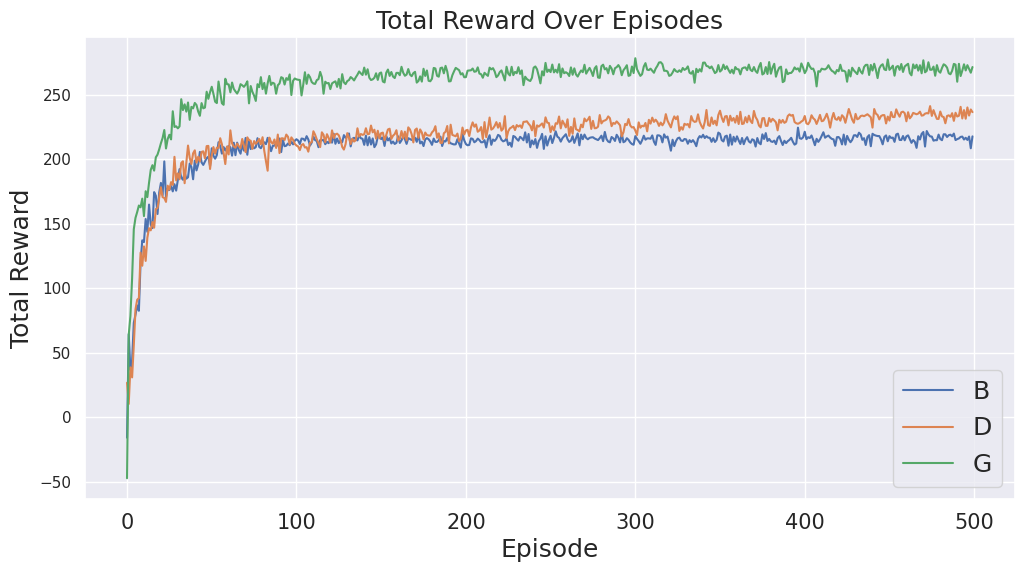

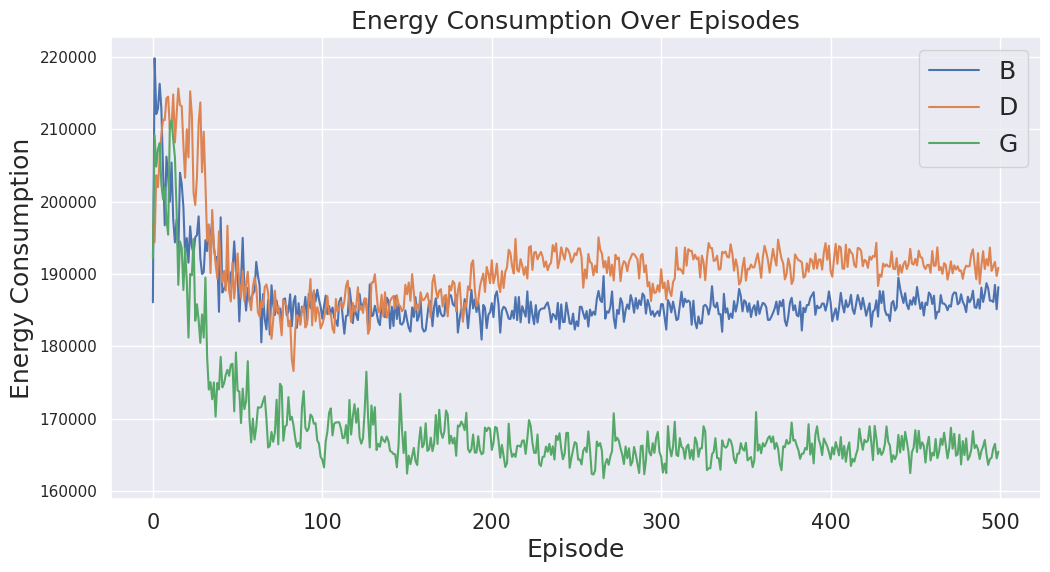

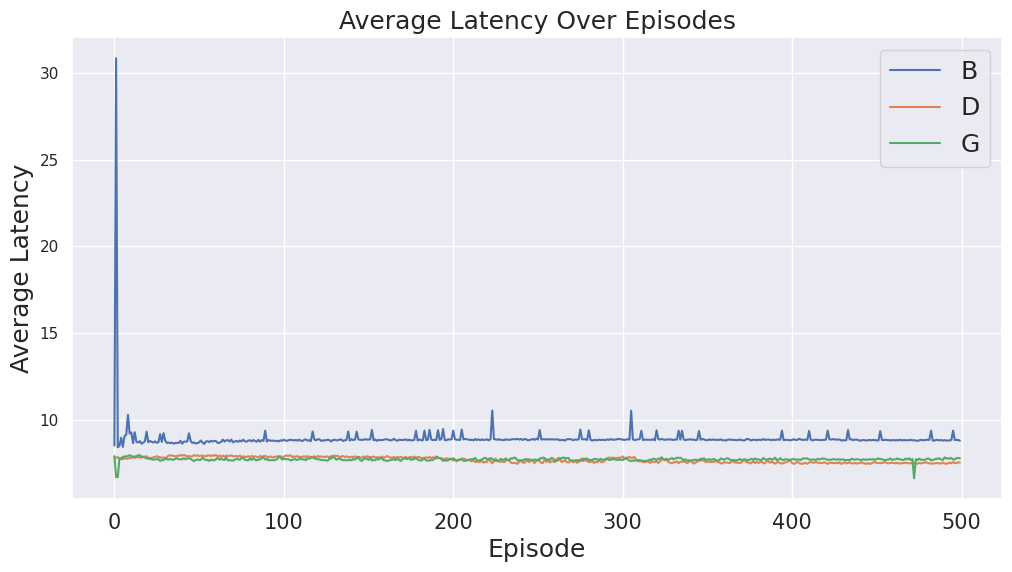

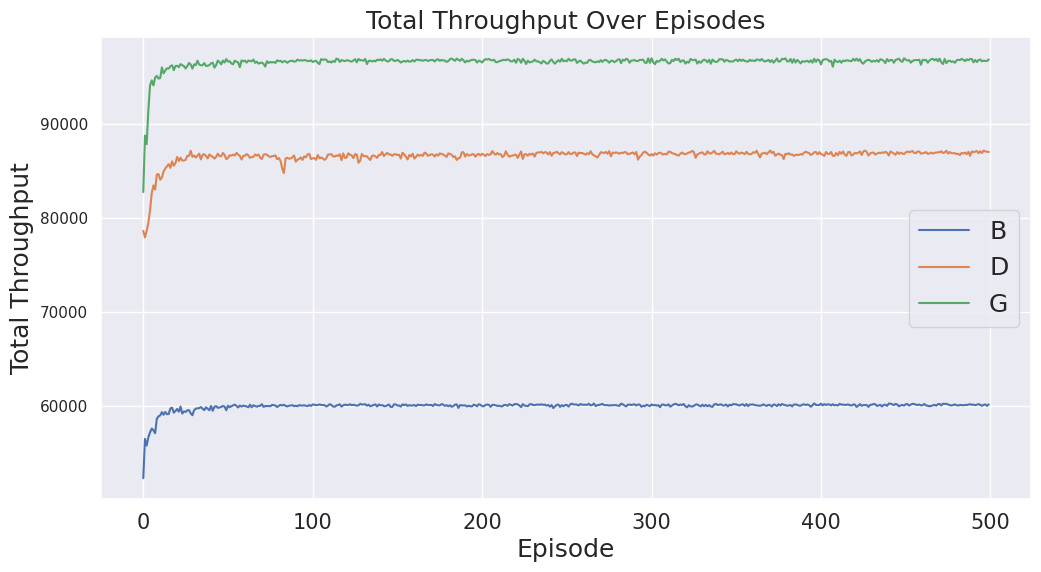

In [15]:
# Plot Total Reward per episode
plot_metric(rewards_history, 'Total Reward', cell_sites)

# Plot Energy consumption per episode
plot_metric(energy_history, 'Energy Consumption', cell_sites)

# Plot Average Latency per episode
plot_metric(latency_history, 'Average Latency', cell_sites)

# Plot Total Throughput per episode
plot_metric(throughput_history, 'Total Throughput', cell_sites)

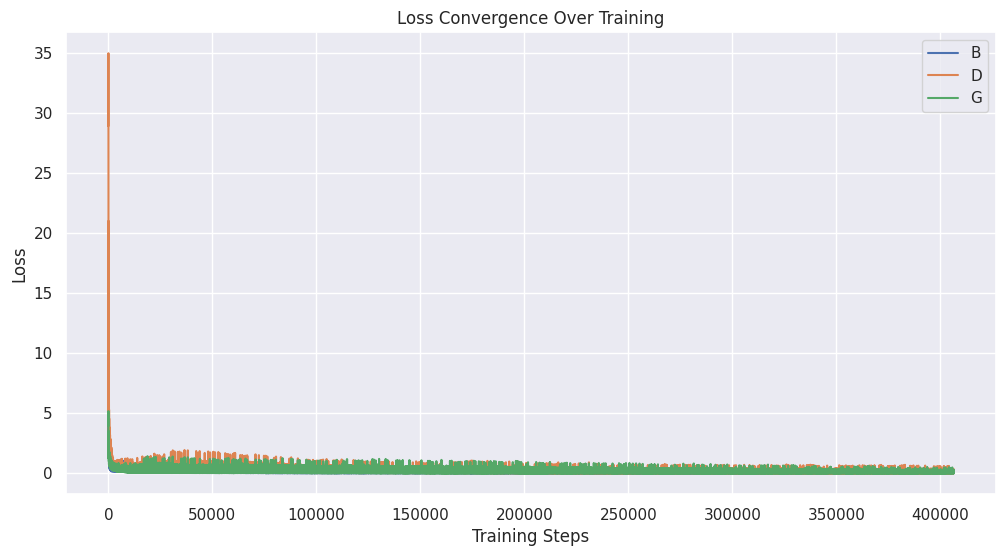

In [16]:
# Plot Loss convergence over training
plt.figure(figsize=(12, 6))
for site in cell_sites:
    plt.plot(loss_history[site], label=f'{site}')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss Convergence Over Training')
plt.legend()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2021959/639028519.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index.astype(str), y=action_counts.values, palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


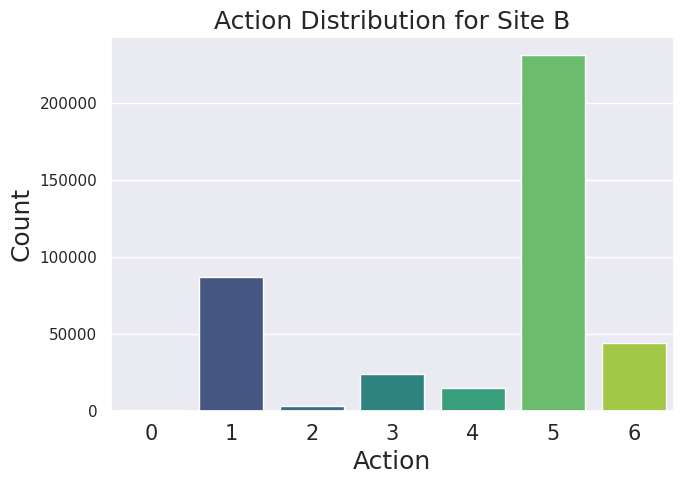

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2021959/639028519.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index.astype(str), y=action_counts.values, palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


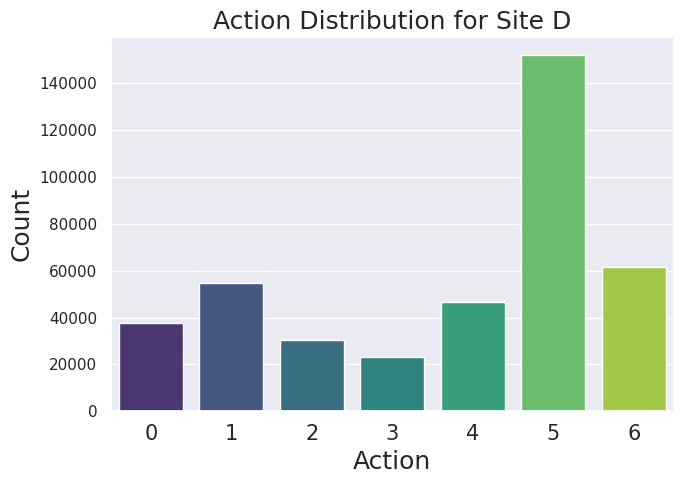

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_2021959/639028519.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_counts.index.astype(str), y=action_counts.values, palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


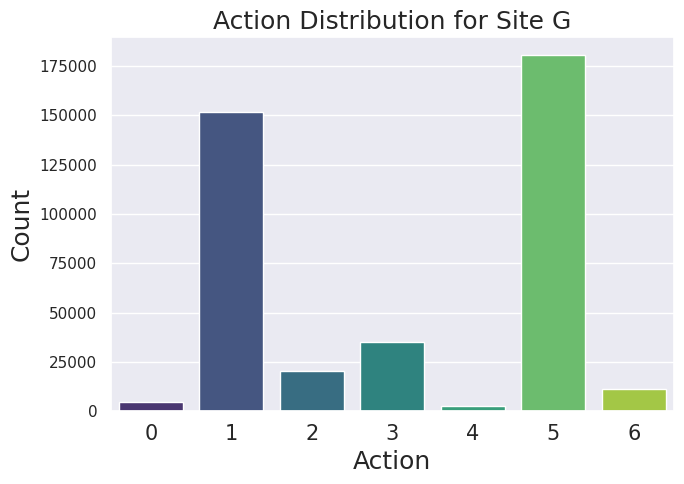

In [17]:
# Plot Action distribution over episodes
for site in cell_sites:
    plt.figure(figsize=(7, 5))
    
    # Pre-aggregate action counts
    action_counts = pd.Series(actions_log[site]).value_counts().sort_index()
    
    # Ensure all actions from 0 to 6 are represented
    all_actions = list(range(env.action_size))
    action_counts = action_counts.reindex(all_actions, fill_value=0)
    
    # Plot using sns.barplot for better aesthetics
    sns.barplot(x=action_counts.index.astype(str), y=action_counts.values, palette='viridis')
    
    plt.xlabel('Action', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(fontsize=15)
    plt.title(f'Action Distribution for Site {site}', fontsize=18)
    plt.tight_layout()
    plt.show()


INFO:__main__:Site B - Energy Savings: 253.40, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 68.10, Normalized: 0.25
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.42
INFO:__main__:Site D - Energy Savings: 241.41, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -9.54, Normalized: -0.04
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.46
INFO:__main__:Site G - Energy Savings: 250.91, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: 6.42, Normalized: 0.02
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.46


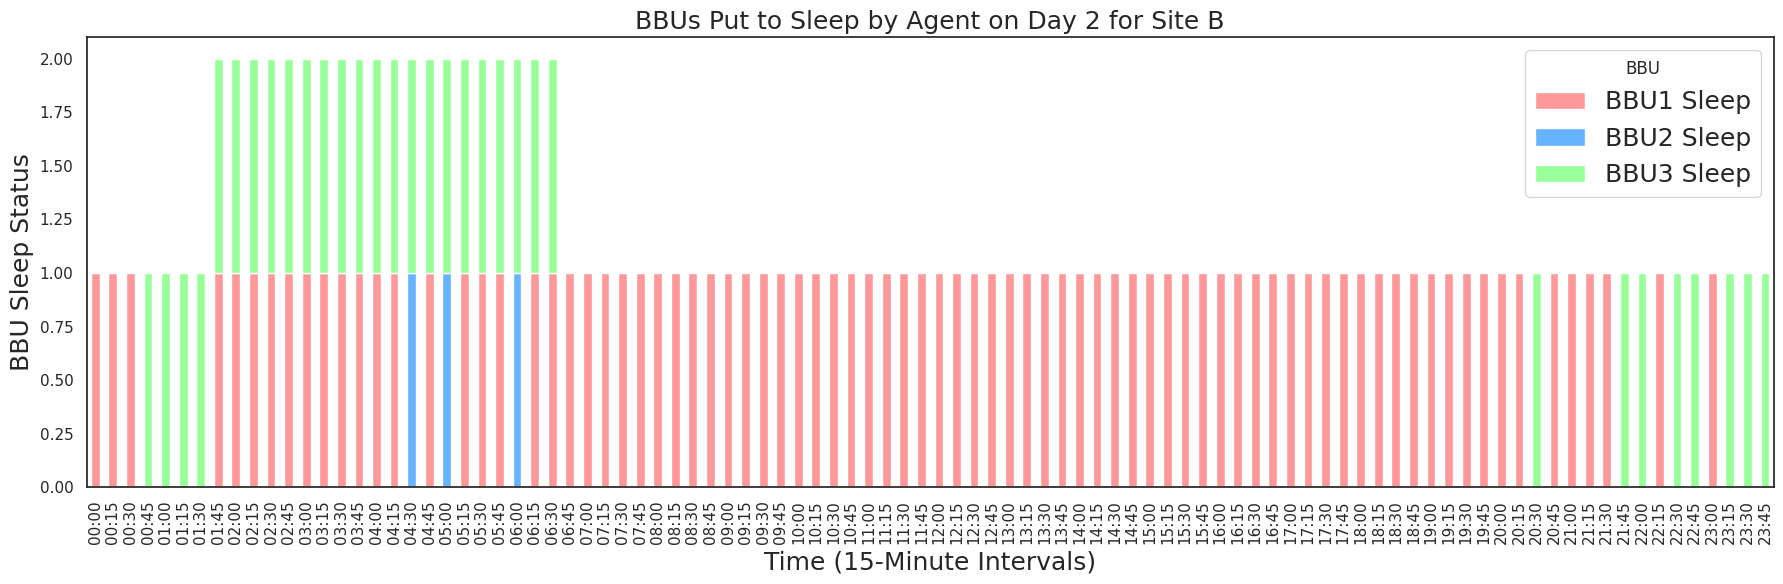

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

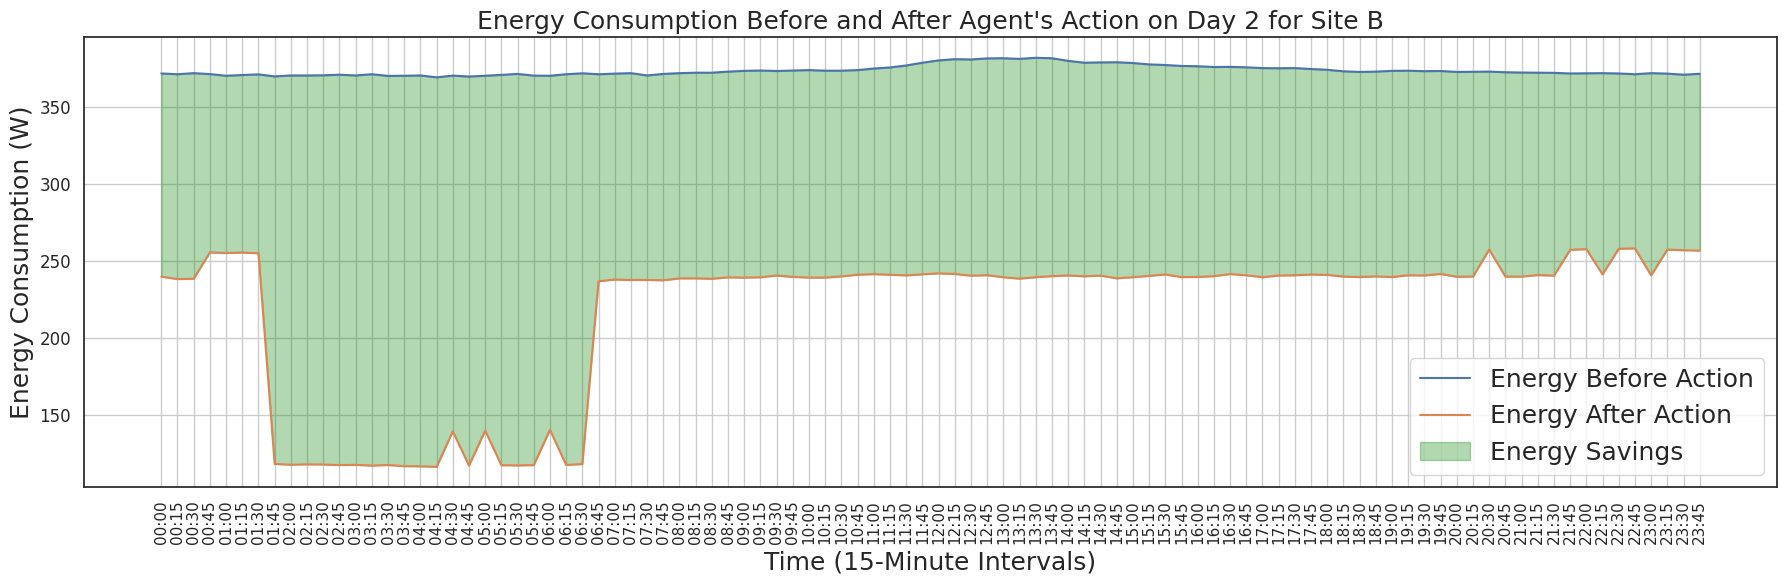

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


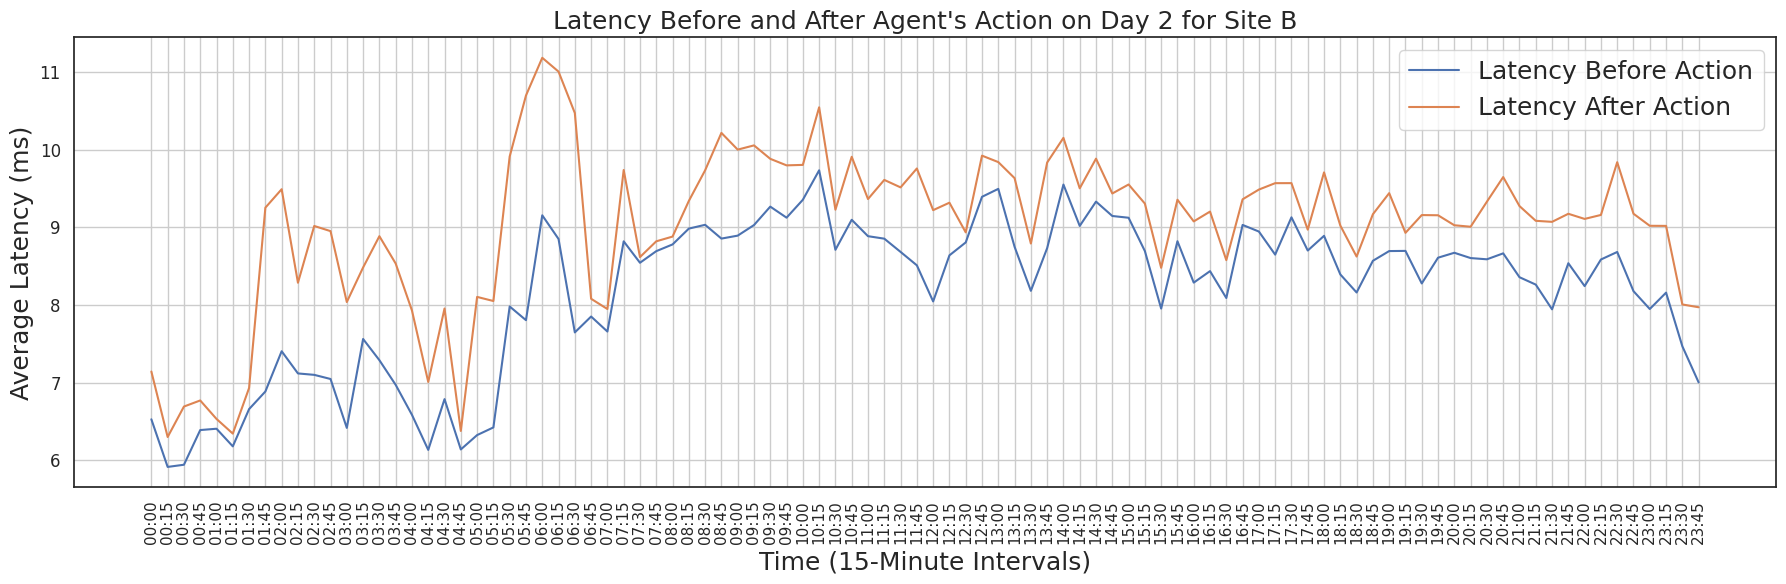

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


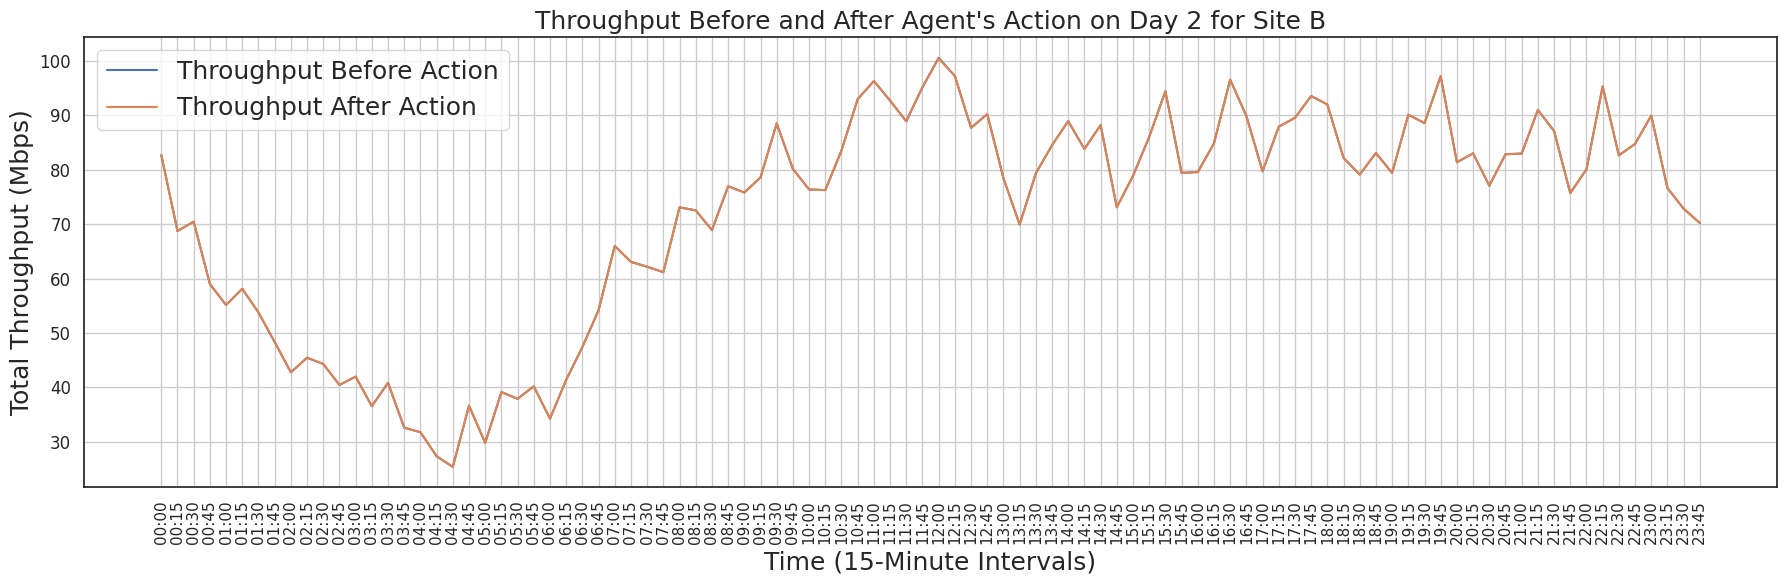


Detailed Metrics for Site B on Day 2:
     Time  Energy_Before  Energy_After  Energy_Saving  Latency_Before  \
0   00:00          372.0    239.794178     132.205822        6.527700   
1   00:15          371.5    238.174603     133.325397        5.914131   
2   00:30          372.2    238.420234     133.779766        5.942120   
3   00:45          371.6    255.544459     116.055541        6.389149   
4   01:00          370.5    255.135465     115.364535        6.406264   
..    ...            ...           ...            ...             ...   
91  22:45          371.5    258.150899     113.349101        8.179168   
92  23:00          372.2    240.617599     131.582401        7.949048   
93  23:15          371.9    257.345413     114.554587        8.159994   
94  23:30          371.2    256.988483     114.211517        7.468714   
95  23:45          371.8    256.710426     115.089574        7.003217   

    Latency_After  Throughput_Before  Throughput_After  
0        7.143170          

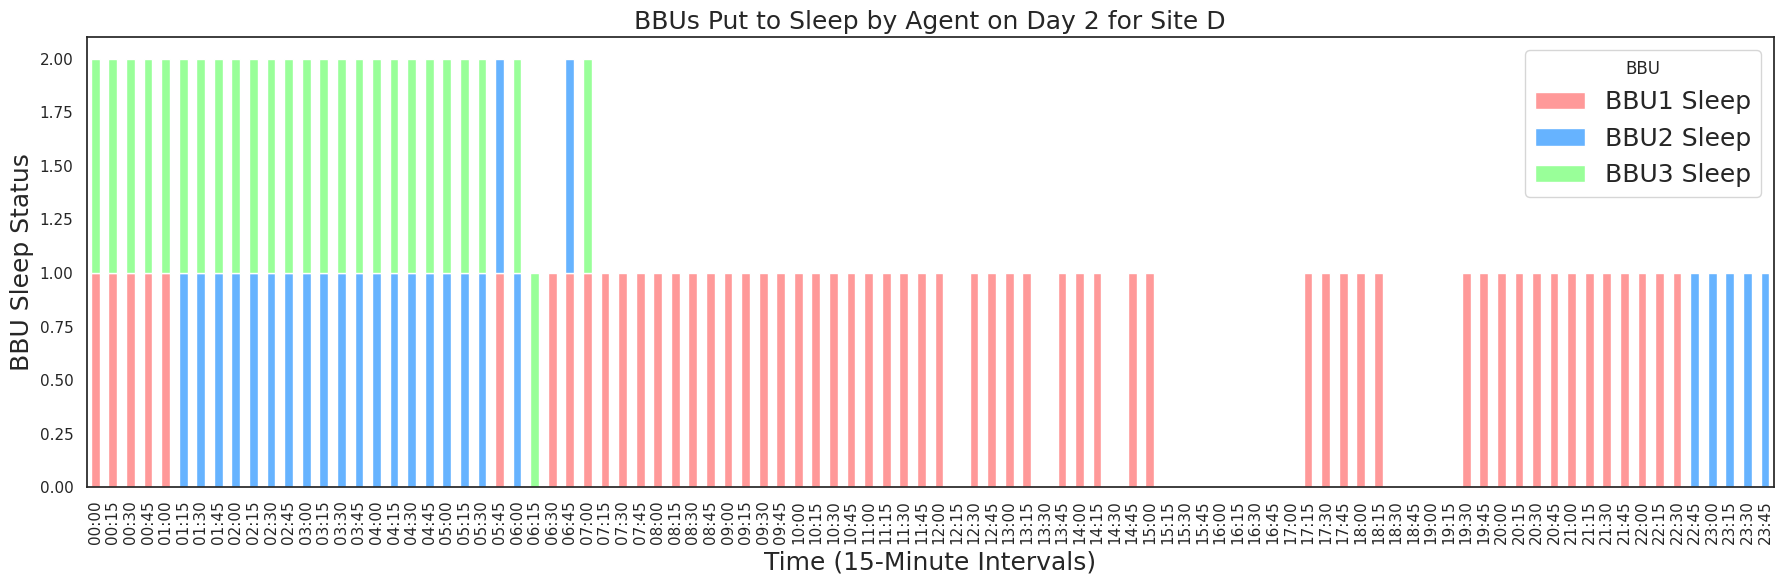

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

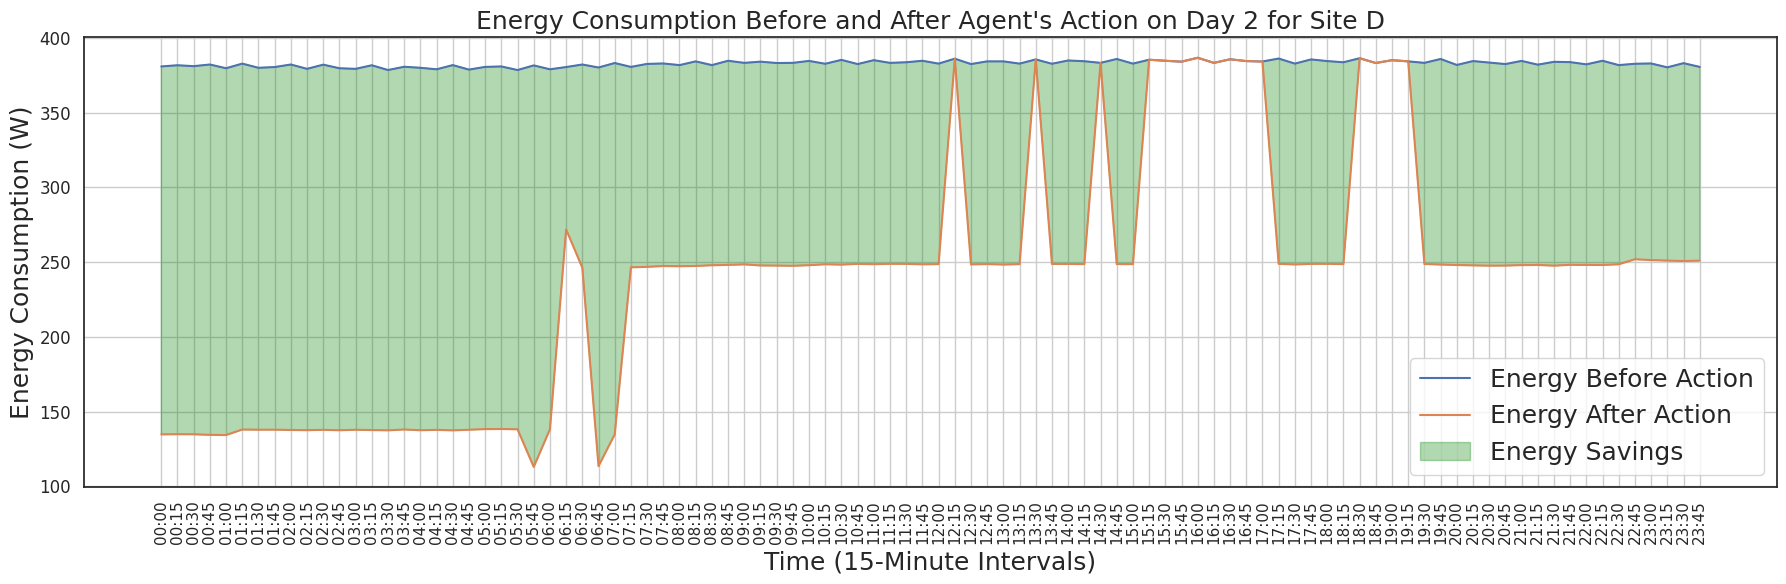

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


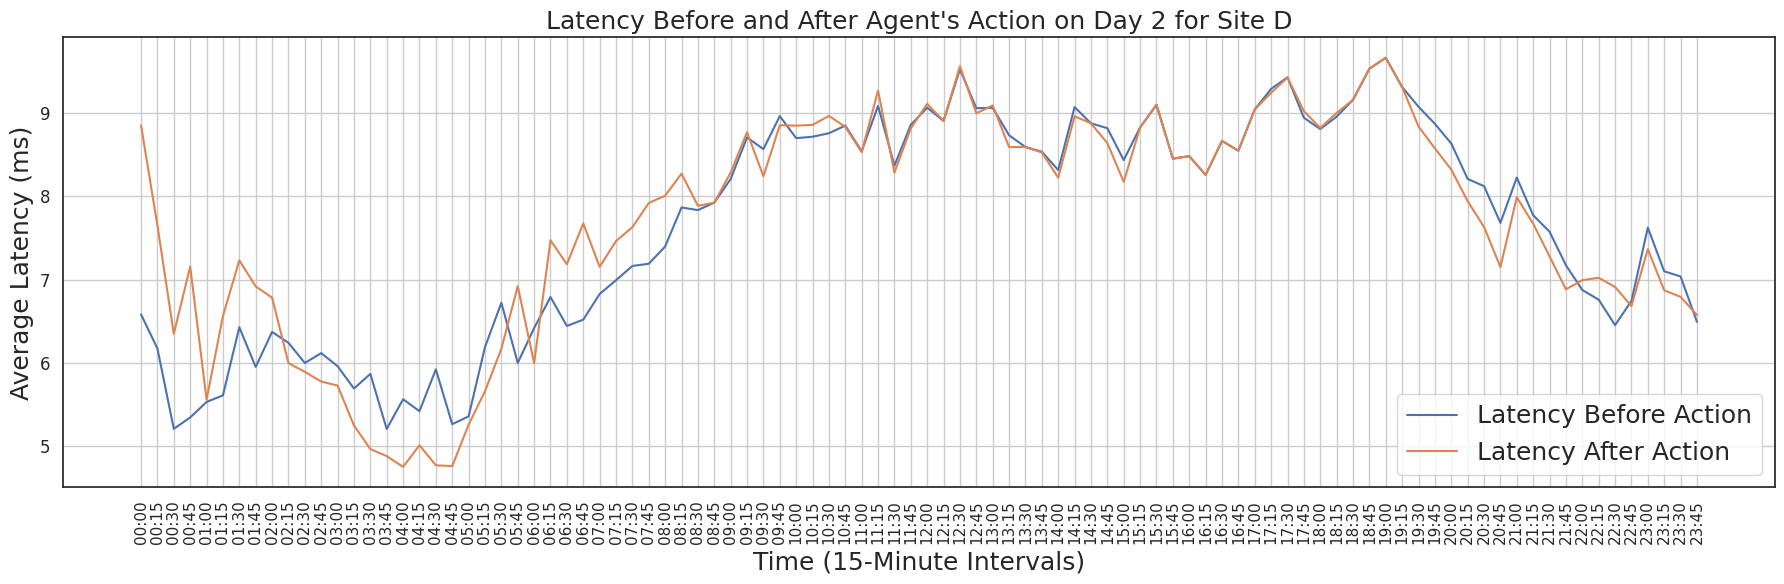

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


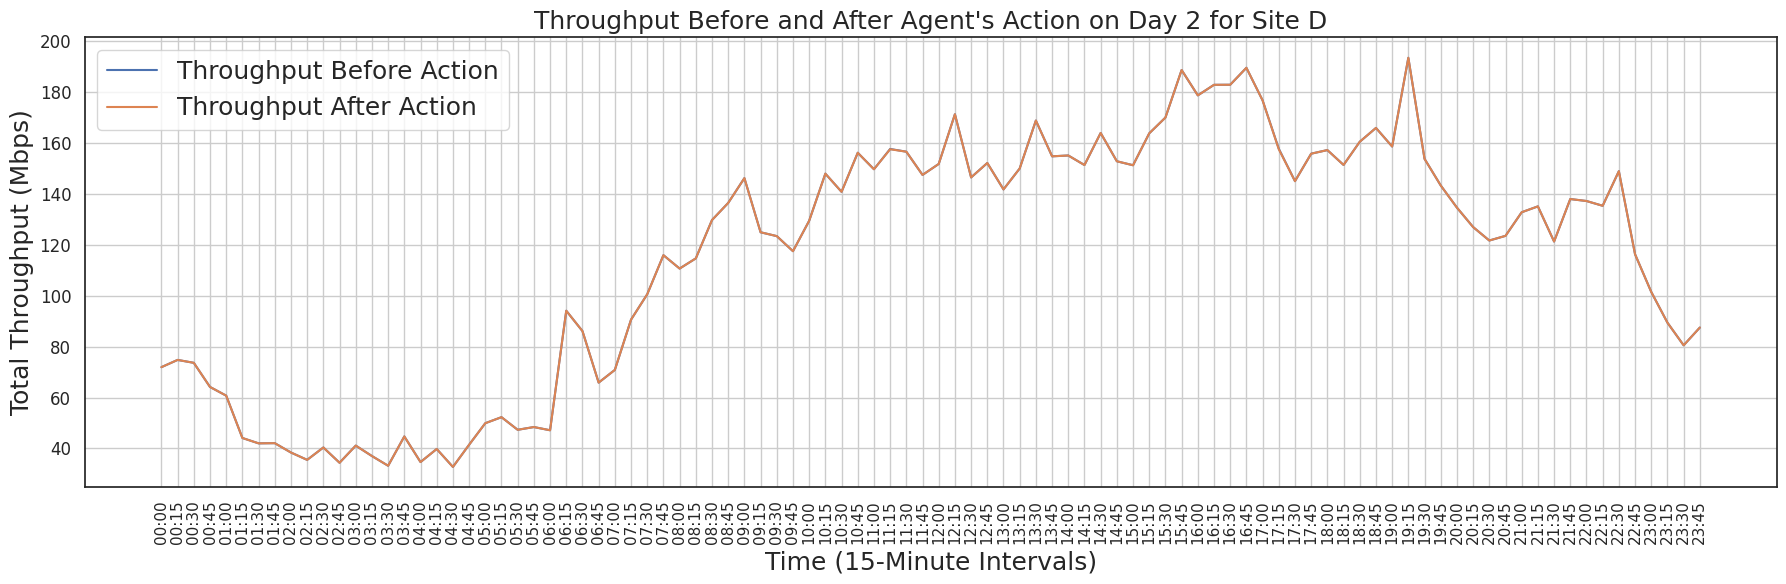


Detailed Metrics for Site D on Day 2:
     Time  Energy_Before  Energy_After  Energy_Saving  Latency_Before  \
0   00:00          380.8    134.687189     246.112811        6.584103   
1   00:15          381.6    134.797834     246.802166        6.173782   
2   00:30          381.0    134.753459     246.246541        5.211032   
3   00:45          382.1    134.384576     247.715424        5.348206   
4   01:00          379.6    134.251530     245.348470        5.533750   
..    ...            ...           ...            ...             ...   
91  22:45          382.6    251.843390     130.756610        6.744981   
92  23:00          382.8    251.277906     131.522094        7.624070   
93  23:15          380.2    250.937621     129.262379        7.100104   
94  23:30          383.0    250.662895     132.337105        7.038203   
95  23:45          380.5    250.929487     129.570513        6.493867   

    Latency_After  Throughput_Before  Throughput_After  
0        8.849742          

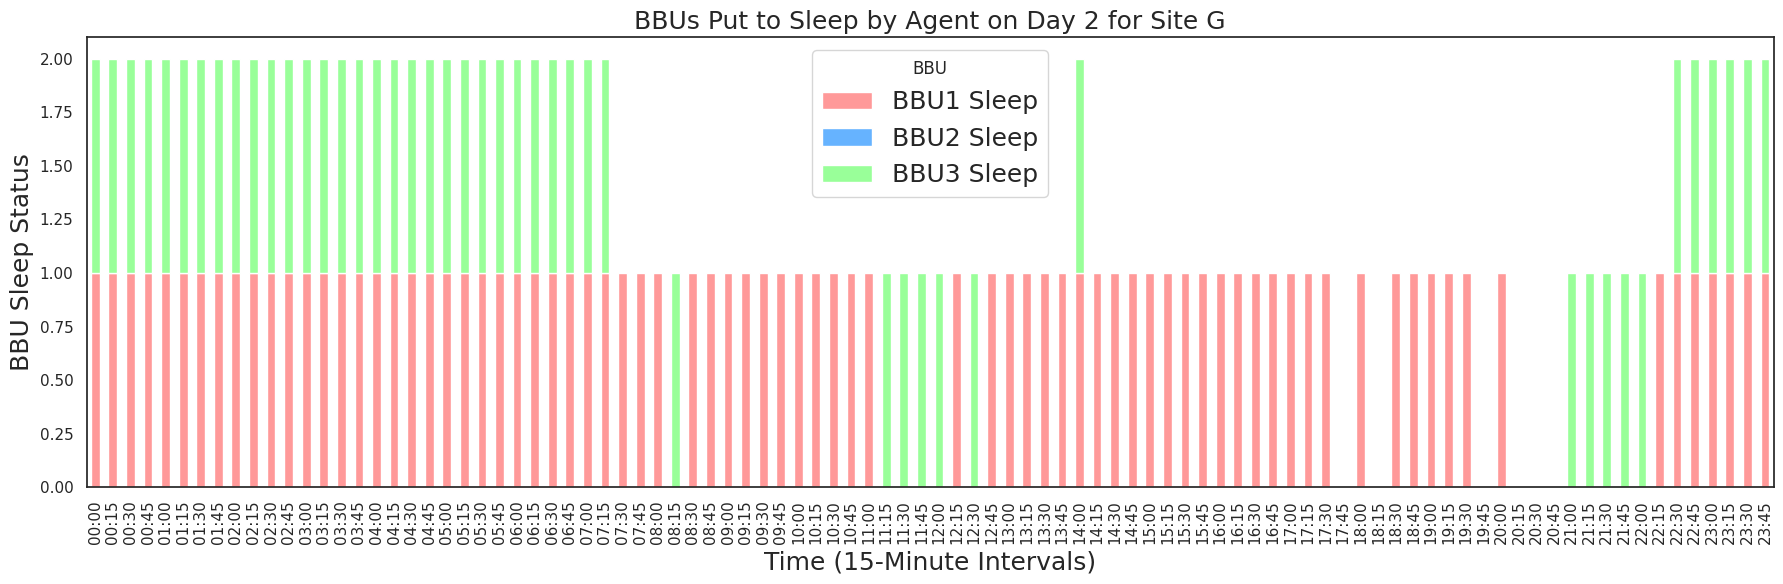

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

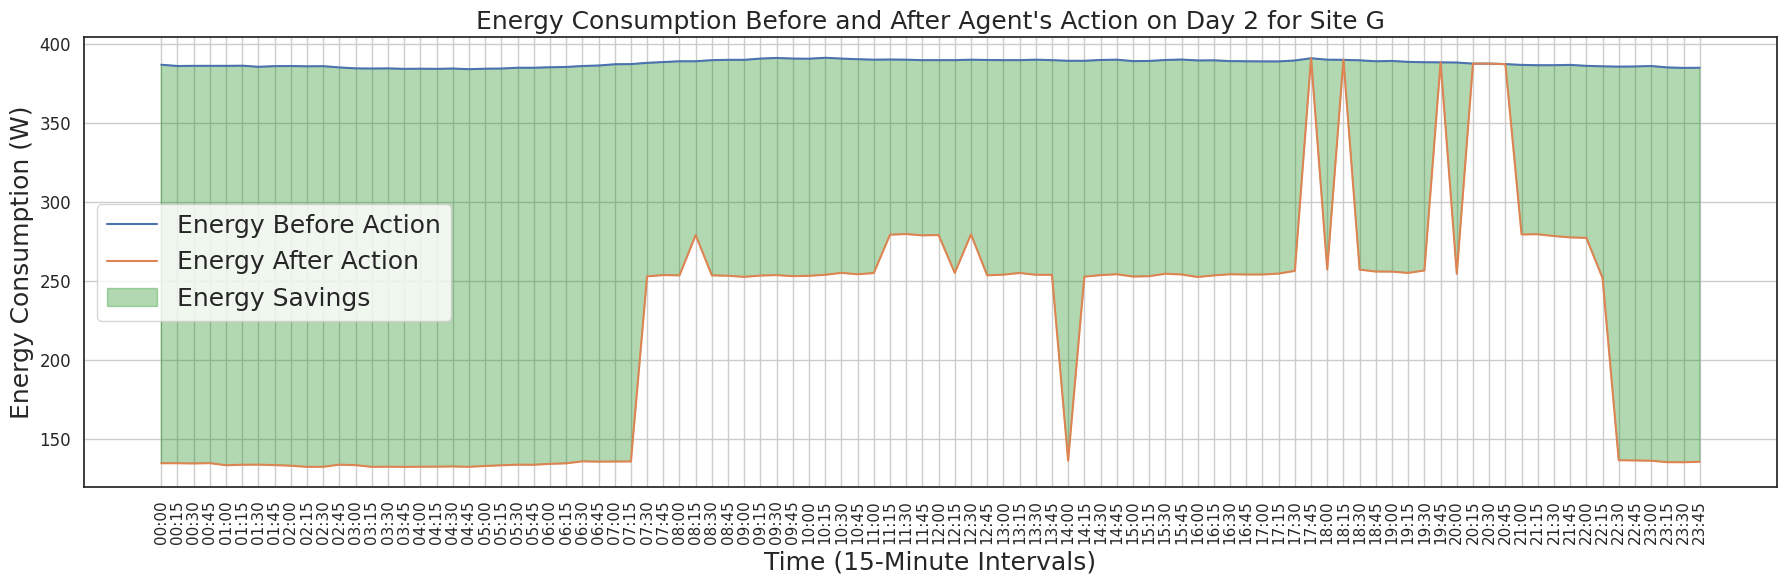

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


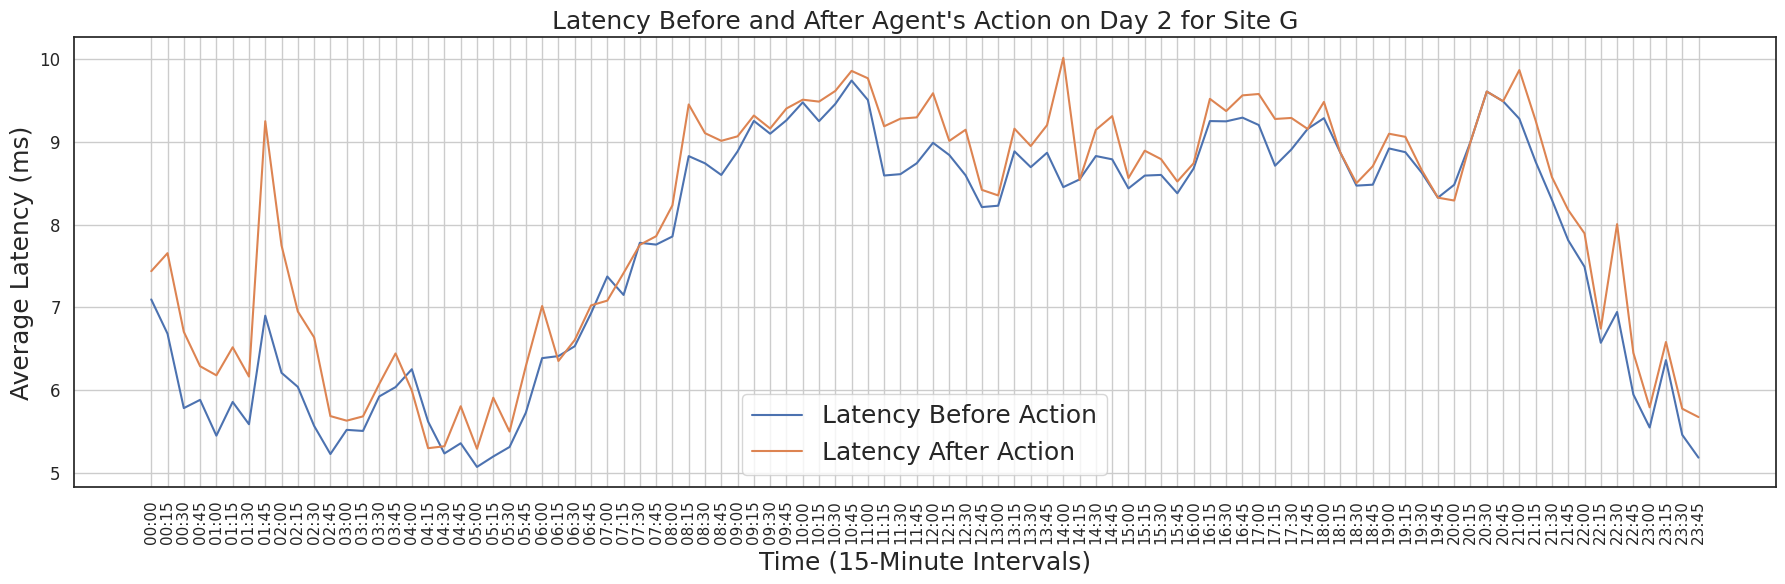

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


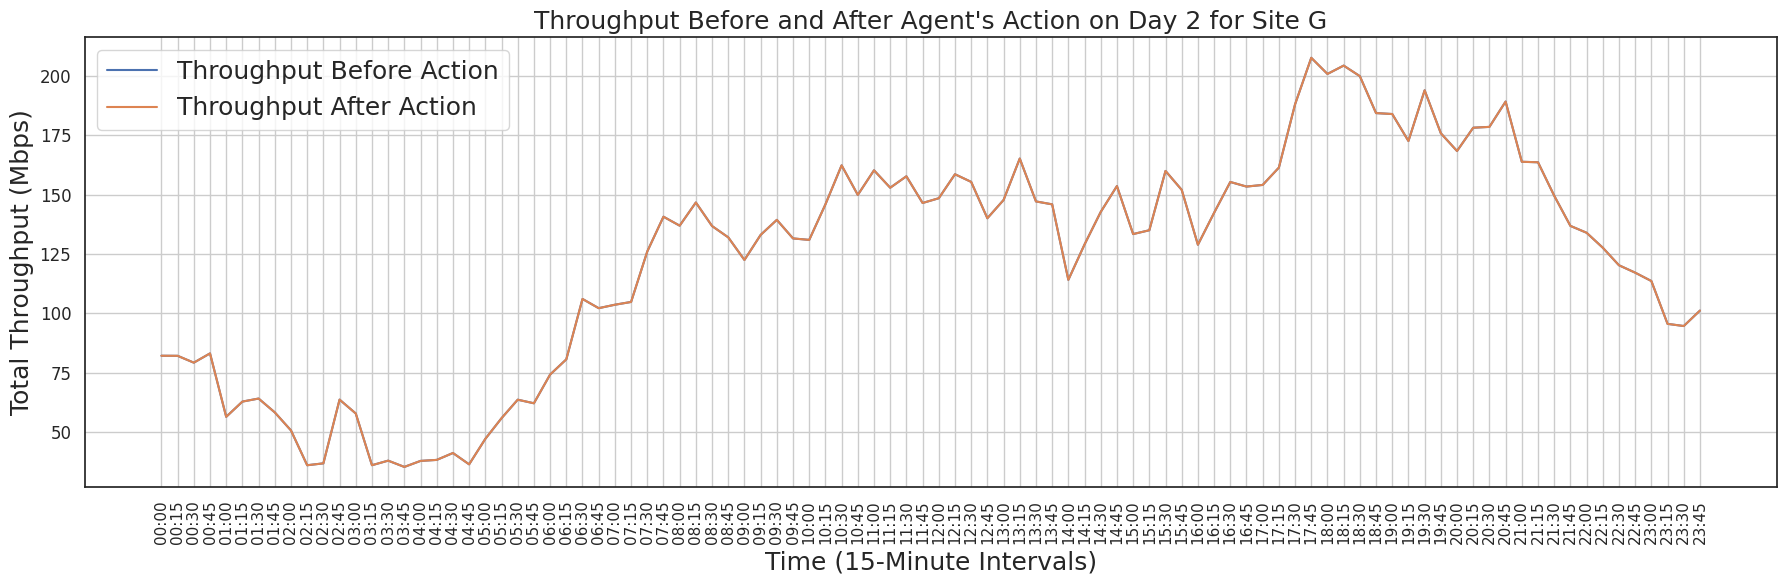


Detailed Metrics for Site G on Day 2:
     Time  Energy_Before  Energy_After  Energy_Saving  Latency_Before  \
0   00:00          386.8    134.803756     251.996244        7.095759   
1   00:15          386.0    134.802261     251.197739        6.682031   
2   00:30          386.1    134.658848     251.441152        5.783356   
3   00:45          386.1    134.852939     251.247061        5.883253   
4   01:00          386.1    133.522403     252.577597        5.450712   
..    ...            ...           ...            ...             ...   
91  22:45          385.7    136.547043     249.152957        5.947889   
92  23:00          386.0    136.371339     249.628661        5.549290   
93  23:15          385.1    135.472737     249.627263        6.362921   
94  23:30          384.8    135.427042     249.372958        5.461037   
95  23:45          384.9    135.751292     249.148708        5.185199   

    Latency_After  Throughput_Before  Throughput_After  
0        7.436973          

In [22]:
# Perform detailed evaluation on a specific day of the week
day_of_week = 2  # Replace with the day number you are interested in (0=Monday, 6=Sunday)
detailed_evaluation(env, agents, day_of_week)


INFO:__main__:Site B - Energy Savings: 253.40, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 68.10, Normalized: 0.25
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.42
INFO:__main__:Site D - Energy Savings: 241.41, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -9.54, Normalized: -0.04
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.46
INFO:__main__:Site G - Energy Savings: 250.91, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: 6.42, Normalized: 0.02
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.46


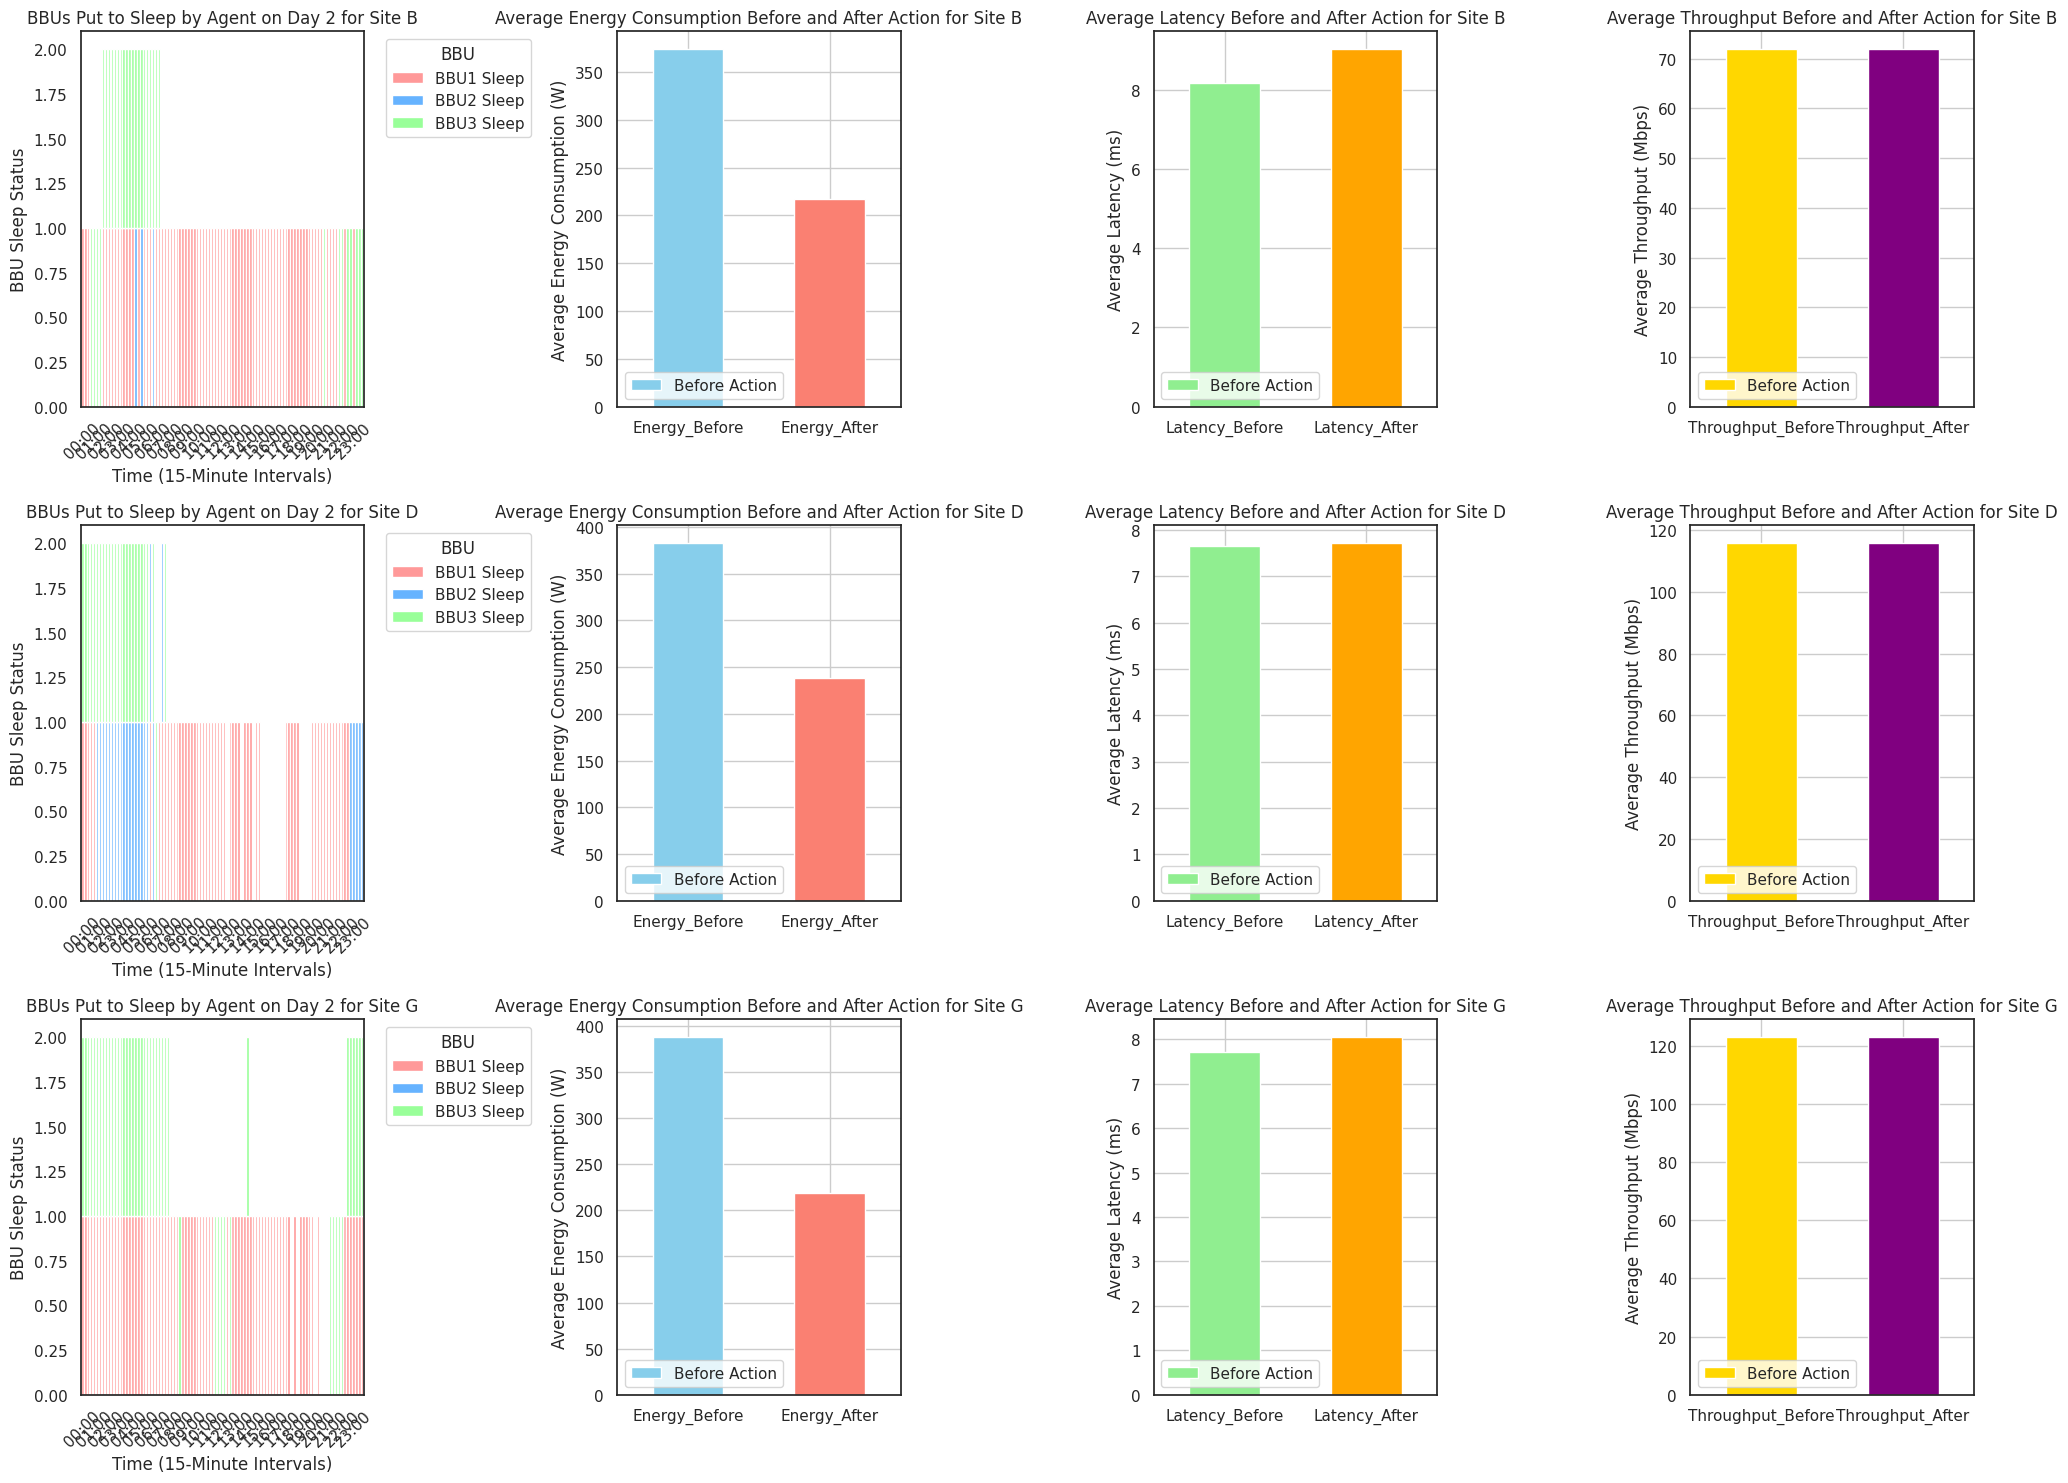


Summary Metrics for Site B on Day 2:
Average Energy Consumption Before Action: 373.91 W
Average Energy Consumption After Action: 217.09 W
Average Energy Saving: 156.82 W
Average Latency Before Action: 8.17 ms
Average Latency After Action: 9.03 ms
Average Throughput Before Action: 71.93 Mbps
Average Throughput After Action: 71.93 Mbps

Summary Metrics for Site D on Day 2:
Average Energy Consumption Before Action: 382.72 W
Average Energy Consumption After Action: 238.12 W
Average Energy Saving: 144.60 W
Average Latency Before Action: 7.65 ms
Average Latency After Action: 7.71 ms
Average Throughput Before Action: 115.70 Mbps
Average Throughput After Action: 115.69 Mbps

Summary Metrics for Site G on Day 2:
Average Energy Consumption Before Action: 387.76 W
Average Energy Consumption After Action: 219.22 W
Average Energy Saving: 168.54 W
Average Latency Before Action: 7.71 ms
Average Latency After Action: 8.04 ms
Average Throughput Before Action: 122.89 Mbps
Average Throughput After Actio

In [23]:
# Perform detailed evaluation on a specific day of the week
day_of_week = 2  # Replace with the day number you are interested in (0=Monday, 6=Sunday)
detailed_evaluation_summary(env, agents, day_of_week)

In [ ]:
print("Date range in the data:", states['Datetime'].min(), "to", states['Datetime'].max())

In [24]:
# Perform detailed evaluation summaryy
weekly_detailed_evaluation_summary(env, agents)

INFO:__main__:Site B - Energy Savings: 132.60, Normalized: 0.36
INFO:__main__:Site B - Latency Increase: 149.10, Normalized: 0.36
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.16
INFO:__main__:Site B - Total Reward: 0.23
INFO:__main__:Site D - Energy Savings: 241.09, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: 64.96, Normalized: 0.22
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.41
INFO:__main__:Site G - Energy Savings: 252.21, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: 9.24, Normalized: 0.02
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.46



--- Evaluating Day 0 (0=Monday, ..., 6=Sunday) ---


INFO:__main__:Site B - Energy Savings: 253.98, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 56.77, Normalized: 0.21
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.43
INFO:__main__:Site D - Energy Savings: 243.63, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: 0.80, Normalized: 0.00
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.45
INFO:__main__:Site G - Energy Savings: 255.28, Normalized: 0.66
INFO:__main__:Site G - Latency Increase: -11.03, Normalized: -0.03
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.47



--- Evaluating Day 1 (0=Monday, ..., 6=Sunday) ---


INFO:__main__:Site B - Energy Savings: 253.40, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 68.10, Normalized: 0.25
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.42
INFO:__main__:Site D - Energy Savings: 241.41, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -9.54, Normalized: -0.04
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.46
INFO:__main__:Site G - Energy Savings: 250.91, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: 6.42, Normalized: 0.02
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.46



--- Evaluating Day 2 (0=Monday, ..., 6=Sunday) ---


INFO:__main__:Site B - Energy Savings: 254.11, Normalized: 0.69
INFO:__main__:Site B - Latency Increase: 132.81, Normalized: 0.69
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.34
INFO:__main__:Site D - Energy Savings: 243.19, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -11.75, Normalized: -0.06
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.47
INFO:__main__:Site G - Energy Savings: 251.37, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: -40.78, Normalized: -0.20
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.50



--- Evaluating Day 3 (0=Monday, ..., 6=Sunday) ---

--- Evaluating Day 4 (0=Monday, ..., 6=Sunday) ---


INFO:__main__:Site B - Energy Savings: 253.05, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 101.81, Normalized: 0.40
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.39
INFO:__main__:Site D - Energy Savings: 243.12, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -0.13, Normalized: -0.00
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.46
INFO:__main__:Site G - Energy Savings: 251.56, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: -26.15, Normalized: -0.12
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.49
INFO:__main__:Site B - Energy Savings: 132.10, Normalized: 0.35
INFO:__main__:Site B - Latency Increase: 52.70, Normalized: 0.


--- Evaluating Day 5 (0=Monday, ..., 6=Sunday) ---


INFO:__main__:Site B - Energy Savings: 253.29, Normalized: 0.69
INFO:__main__:Site B - Latency Increase: 31.94, Normalized: 0.19
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.44
INFO:__main__:Site D - Energy Savings: 240.28, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -22.92, Normalized: -0.10
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.47
INFO:__main__:Site G - Energy Savings: 251.81, Normalized: 0.66
INFO:__main__:Site G - Latency Increase: -11.51, Normalized: -0.06
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.47
INFO:__main__:Site B - Energy Savings: 115.93, Normalized: 0.31
INFO:__main__:Site B - Latency Increase: 37.48, Normalized: 0.


--- Evaluating Day 6 (0=Monday, ..., 6=Sunday) ---


INFO:__main__:Episode finished.


Info is None for Day 6 at index 813

=== Weekly Summary Metrics for Each Site per Day ===
Site  Day_of_Week  Avg_Energy_Before  Avg_Energy_After  Avg_Energy_Saving  Avg_Latency_Before  Avg_Latency_After  Avg_Throughput_Before  Avg_Throughput_After
   B            0         379.355208        246.786994         132.568214            8.059593           8.987299              80.405323             80.078329
   B            1         372.950000        238.112232         134.837768            8.493433           9.550016              78.695615             78.582474
   B            2         373.906250        217.088246         156.818004            8.169227           9.025380              71.929208             71.927844
   B            3         374.985417        225.622011         149.363406            7.924739           8.987154              74.889156             74.849792
   B            4         373.472258        246.367401         127.104857            8.072448           8.803483        

,Site,Day_of_Week,Avg_Energy_Before,Avg_Energy_After,Avg_Energy_Saving,Avg_Latency_Before,Avg_Latency_After,Avg_Throughput_Before,Avg_Throughput_After
0,B,0,379.355208,246.786994,132.568214,8.059593,8.987299,80.405323,80.078329
1,B,1,372.950000,238.112232,134.837768,8.493433,9.550016,78.695615,78.582474
2,B,2,373.906250,217.088246,156.818004,8.169227,9.025380,71.929208,71.927844
3,B,3,374.985417,225.622011,149.363406,7.924739,8.987154,74.889156,74.849792
4,B,4,373.472258,246.367401,127.104857,8.072448,8.803483,79.974948,79.974948
5,B,5,374.334239,203.871180,170.463059,7.662763,8.545505,65.740347,65.740347
6,B,6,377.794307,234.016588,143.777719,7.222937,8.268846,74.302083,74.148478
7,D,0,383.308333,262.041345,121.266988,7.621554,7.749614,118.505927,118.505927
8,D,1,383.231250,265.232728,117.998522,7.470894,7.579432,121.235656,121.226303
9,D,2,382.717708,238.116425,144.601283,7.648567,7.710940,115.695365,115.692158
